In [1]:
!poetry add pyarrow
!poetry add seaborn

The following packages are already present in the pyproject.toml and will be skipped:

  - pyarrow

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.
The following packages are already present in the pyproject.toml and will be skipped:

  - seaborn

If you want to update it to the latest compatible version, you can use `poetry update package`.
If you prefer to upgrade it to the latest available version, you can use `poetry add package@latest`.

Nothing to add.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use("ggplot")
pd.pandas.set_option("display.max_columns", None)

# Summary of insights

The shape of the dataset:
- 0   fecha       datetime64[ns]
- 1   codparcela  object        
- 2   lat         float64       
- 3   lon         float64       
- 4   indice      object        
- 5   valor       float64

We have the following weather indices: (NDVI, SAVI, GNDVI), SSM, LTS, FAPAR, NDWI, SIPI

## 1. Missing values analysis

Proportion of missing values:
- Only FAPAR, LST and SSM weather indices have missing values.
  - 8.2458 % missing values in FAPAR
  - 32.1059 % missing values in LST
  - 73.9045 % missing values in SSM

Distribution in time of missing values:
- FAPAR has missing values from 2020 onwards.
- LST and SSM's missing values are distributed among the entire date range.

Geographic distribution of missing values:
- Missing values are mostly INDEPENDENT of geographic location of the sample.\
  However, all or most of the codparcelas with latitude < 10 or latitude > 43, ONLY have\
  missing values. We can consider DELETING those parcelas, as they don't contain useful\
  data.

Types of missing value for each weather indice:
- SSM indice is MNAR. The reason is that the dataset given has 1 sample per day,
  a frequency of 1 day. However, only every 5 days, it has a value, whereas for\
  other days, it is NaN. Thus, in reality, the samples are every 5 days, so, we
  can delete the NaN values of the SSM indice.
- FAPAR and LST indices missing values are MAR. Impute them.

For each parcela:
- All codparcela's have a missing value proportion of 20% of their samples,\
  which could be due to the SSM indice mentioned above.

TODO:
- Drop all NaN’s for SSM.
- Impute NaN’s for FAPAR and LST. (LOCF?)
- Drop parcelas with latitude < 10 or latitude > 43.


## 2 and 3. Numerical variables analysis

Weather indices values:
- FAPAR from 2020 onwards, have value 0 or close, because the values have been normalized.\
  It coincides with the dates where there are missing values. Also, there are points\
  with constant 255 value, are they outliers?
- For NDVI, NDWI, SAVI, GNDVI and SIPI indices, contain lots of 0 values, and\
  those are in reality, missing values, they have exactly 0.0 as value, and also\
  because they follow a certain date interval pattern. We have been given a\
  small time resolution, but in reality, it is bigger.
- All looks good for SSM and LST.

- TODO:
  - FAPAR: normalize values up until 2020 (dividing by 255) and drop rows with value > 250,\
    which are probably outliers.
  - NDVI, NDWI, SAVI, GNDVI and SIPI: drop rows with value exactly 0.0.
  
## 4 and 5. Categorical variables analysis
8 weather indices: SSM, NDVI, NDWI, GNDVI, SAVI, SIPI, FAPAR, LST.
Distribution of samples by indice:
  - SSM: 27,12%
  - NDVI: 13,49%
  - NDWI: 13,49%
  - GNDVI: 13,49%
  - SAVI: 13,49%
  - SIPI: 13,49%
  - FAPAR: 02,71%
  - LST: 02,69%\
  It includes NaNs and not valid rows, so it is not representative.

### 6. Frequency of samples in days for each weather indice:
- FAPAR: 10
- GNDVI: 5
- LST: 10
- NDVI: 5
- NDWI: 5
- SAVI: 5
- SIPI: 5
- SSM: 5

### Geographic location of samples (latitude, longitude)

- Most of them are close to latitude 38, and with longitude between -7.5 and 0,
  which is the south of Spain.

## 7. Steps to clean the data
1. Combine splitted indices
2. Drop all NaN’s for SSM.
3. NDVI, NDWI, SAVI, GNDVI and SIPI: drop rows with value exactly 0.0.
4. FAPAR: normalize values up until 2020 (dividing by 255) and drop rows with\
   value > 250, which are probably outliers.
5. Impute NaN’s for FAPAR and LST. (LOCF?)
6. Drop parcelas with latitude < 10 or latitude > 43.
7. Drop parcelas with not much data

## 8. Feature engineering
For each weather indice create:
- Temporal differences: diff last 5, 10, 15 days.
- Moving Averages: average of 15 days, of 30 days
- Temporal statistics:
  - mean, median, std, min, max
  - of last 15 days, 30 days, etc

## Data analysis

In [2]:
data_path = '../../data'

In [3]:
meteo = pd.read_parquet(f"{data_path}/meteo_parcelas.parquet")

In [5]:
meteo.shape

(31892562, 6)

In [6]:
meteo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31892562 entries, 9529662 to 9529661
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   fecha       datetime64[ns]
 1   codparcela  object        
 2   lat         float64       
 3   lon         float64       
 4   indice      object        
 5   valor       float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.7+ GB


In [7]:
meteo.head()

fecha       codparcela        lat       lon indice  valor
9529662 2018-01-10  023-00109-00-00  37.146121 -2.769372  FAPAR  255.0
9529663 2018-01-10  027-00047-00-00  37.140687 -2.772991  FAPAR  127.0
9529664 2018-01-10  016-00014-00-00  37.157344 -2.816261  FAPAR   55.0
9529665 2018-01-10  022-00237-00-00  37.146910 -2.795299  FAPAR  255.0
9529666 2018-01-10  012-00154-00-00  37.205017 -1.919212  FAPAR   33.0

## Stuff to look for in Data Analysis

1. Missing Values
2. All the numerical values
3. Distribution of numerical values
4. Categorical values
5. Cardinality of categorical variables
6. Outliers
7. Relationship between independent and dependent feature

From an analysis made in the next sections, there are some indices that can be\
grouped together. I will perform the grouping here so that the analysis are\
done for all of the indices.

In [9]:
meteo["indice"].value_counts()

indice
SSM                                                                             8650530
SIPI                                                                            4303530
NDVI                                                                            4303530
NDWI                                                                            4303530
FAPAR                                                                            864642
                                                                                 ...   
S2A_MSIL2A_20211002T104901_N0301_R051_T30SWG_20211002T140006_savi                  4830
S2A_MSIL2A_20211002T104901_N0301_R051_T30SWG_20211002T140006_resampled_gndvi       4830
S2A_MSIL2A_20210928T110841_N0301_R137_T30SUG_20210928T141544_savi                  4830
S2A_MSIL2A_20210928T110841_N0301_R137_T30SUG_20210928T141544_resampled_gndvi       4830
S2A_MSIL2A_20231015T110011_N0509_R094_T30SVG_20231015T170859_resampled_gndvi       4830
Name: count, Length: 1788

In [10]:
meteo["indice"] = meteo["indice"].apply(lambda x: x.split("_")[-1].upper())

In [11]:
meteo["indice"].value_counts()

indice
SSM      8650530
NDVI     4303530
NDWI     4303530
GNDVI    4303530
SAVI     4303530
SIPI     4303530
FAPAR     864642
LST       859740
Name: count, dtype: int64

## 1. Missing Values

In [12]:
features_with_na = [feature for feature in meteo.columns if meteo[feature].isnull().sum() > 1]
for feature in features_with_na:
    print(feature, np.round(meteo[feature].isnull().mean()*100, 4), "% missing values")

valor 21.1349 % missing values


Calculate the percentage of NaNs for each weather index

In [13]:
indice_grp = meteo.groupby("indice")

In [14]:
indices_with_nans = [ indice for indice, df_group in indice_grp if df_group["valor"].isnull().sum() > 1 ]
for indice in indices_with_nans:
    print(np.round(indice_grp.get_group(indice)[feature].isnull().mean()*100, 4), "% missing values in", indice)

8.2458 % missing values in FAPAR
32.1059 % missing values in LST
73.9045 % missing values in SSM


In [15]:
print("Num. of indices:", indice_grp.ngroups)

Num. of indices: 8


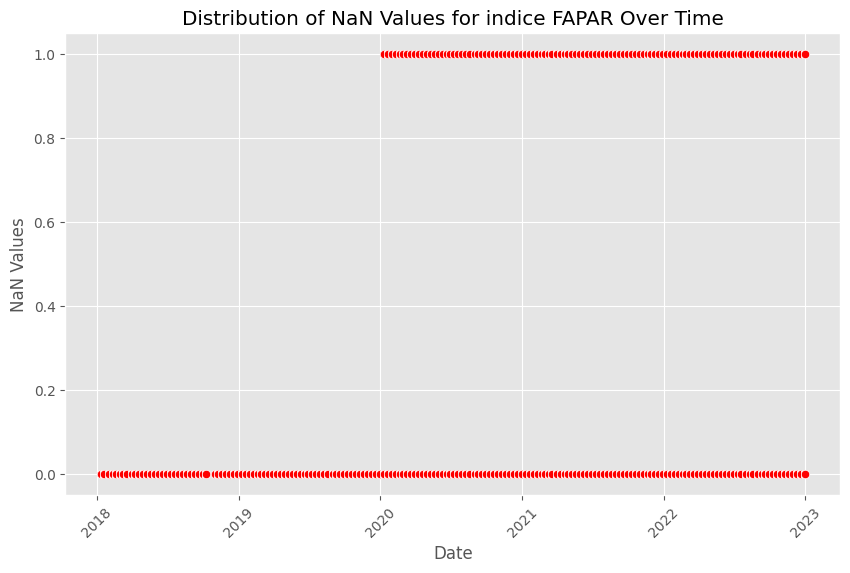

Number of NaN values for indice FAPAR: 71297


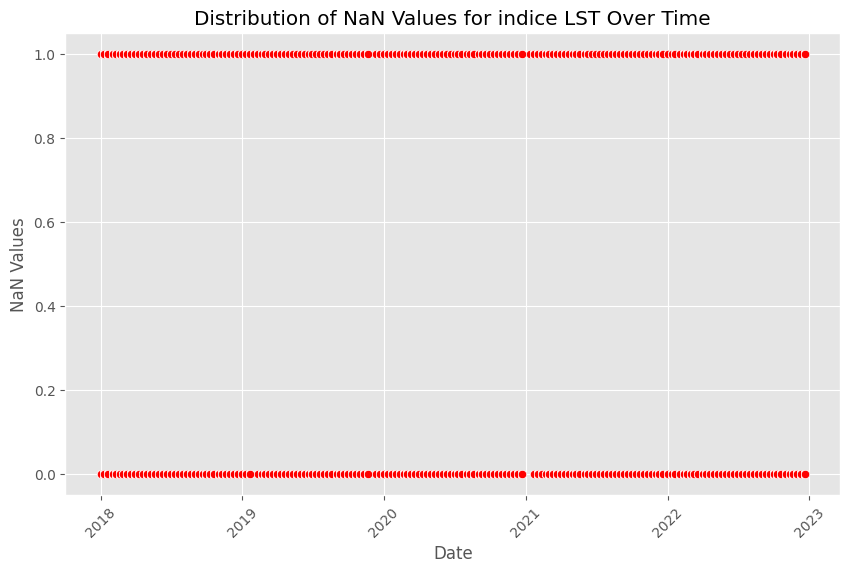

Number of NaN values for indice LST: 276027


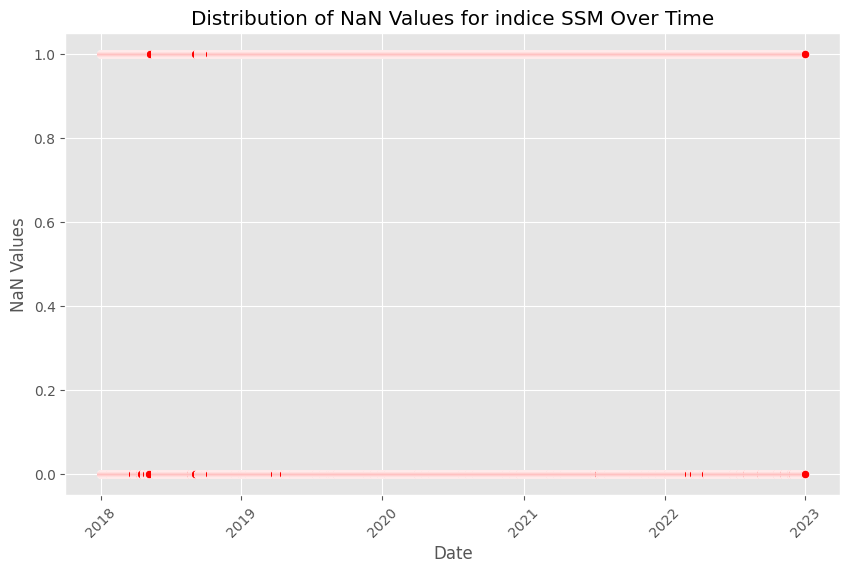

Number of NaN values for indice SSM: 6393133


In [17]:
for name, group in indice_grp:
    if name not in indices_with_nans:
        continue
    # Count NaN values for the 'valor' column in each group
    nan_count = group['valor'].isnull().sum()

    # Plot NaN values over time using Seaborn scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=group, x='fecha', y=group['valor'].isnull(), color='red', marker='o')
    plt.title(f'Distribution of NaN Values for indice {name} Over Time')
    plt.xlabel('Date')
    plt.ylabel('NaN Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    # Print the number of NaN values for the 'valor' column in each group
    print(f"Number of NaN values for indice {name}: {nan_count}")


Insights:
- Only FAPAR, LST and SSM weather indices value's contain missing values.
  - 8.2458 % missing values in FAPAR
  - 32.1059 % missing values in LST
  - 73.9045 % missing values in SSM

- FAPAR has missing values from 2020 onwards.
- LST and SSM's missing values are distributed among the entire date range.
  
- What kind of missing values are they? Are they specific to codparcelas?\ Why do they happen?

### 1.1 Figuring out why missing values happen

### 1.1.1 Analysing Spatial Distribution of Missing Values

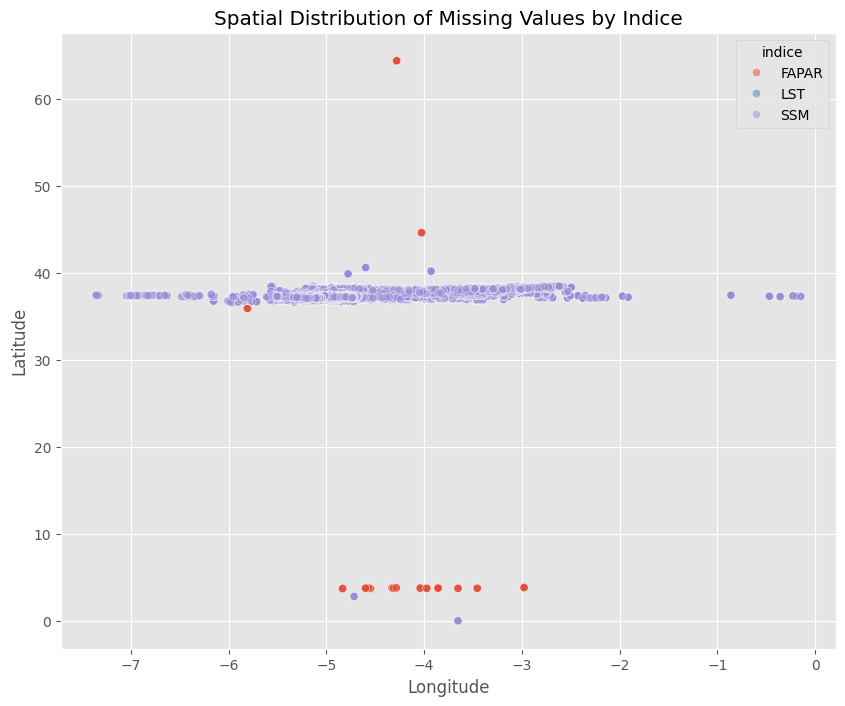

In [16]:
nan_indice_filter = meteo["indice"].isin(indices_with_nans)
isnan_filter = meteo["valor"].isnull()
missing_values_df = meteo[nan_indice_filter & isnan_filter]

# Create a scatter plot with transparency to visualize overlapping points
plt.figure(figsize=(10, 8))

# Plot the scatter plot with hue based on "indice" and adjust transparency to avoid overlapping points
sns.scatterplot(x="lon", y="lat", data=missing_values_df, hue="indice", alpha=0.5)

plt.title('Spatial Distribution of Missing Values by Indice')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)  # Add grid to differentiate overlapping points
plt.show()


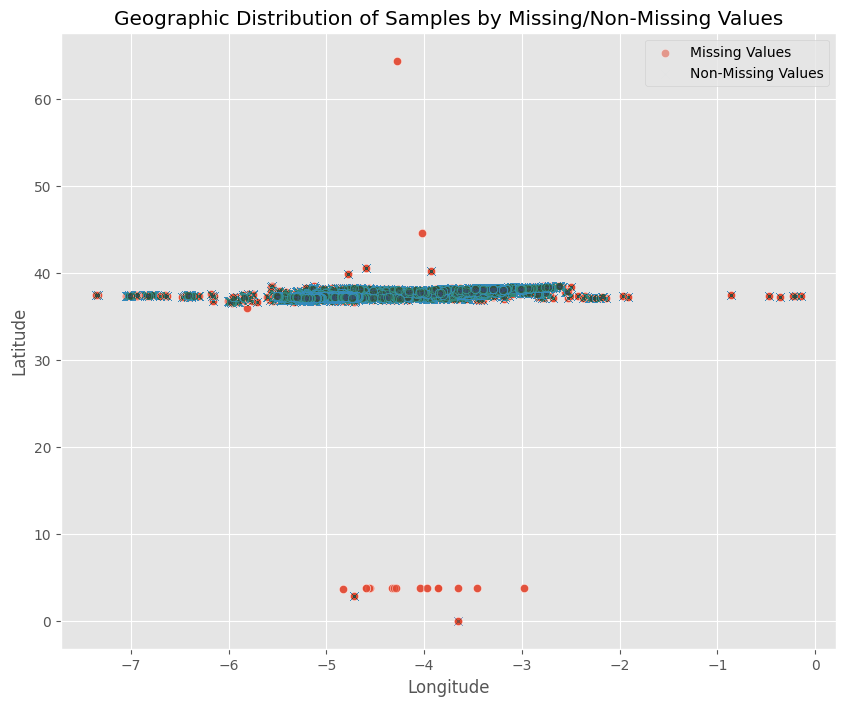

In [18]:
# Step 1: Filter out rows with missing values in 'valor' feature
non_missing_values_df = meteo[nan_indice_filter & (~isnan_filter)]

# Step 2: Visualize the spatial distribution
plt.figure(figsize=(10, 8))

# Plot missing values with a smaller marker size and higher transparency
sns.scatterplot(x='lon', y='lat', data=missing_values_df, alpha=0.5, marker='o', label='Missing Values')

# Plot non-missing values with a larger marker size and lower transparency
sns.scatterplot(x='lon', y='lat', data=non_missing_values_df, alpha=0.01, marker='x', label='Non-Missing Values')

plt.title('Geographic Distribution of Samples by Missing/Non-Missing Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)  # Add grid to differentiate overlapping points
plt.show()

Missing Values Insights:
- Missing values are INDEPENDENT of geographic location of the sample.
- However, codparcelas with latitude < 10 and latitude > 43, most of them ONLY have\
  missing values. We can consider DELETING them, as they don't contain useful data.

Geographic location of samples insights:
- Most of them are close to latitude 38, and with longitude between -7.5 and 0,\
  which is the south of Spain.

### 1.1.2 Parcel-Level Analysis

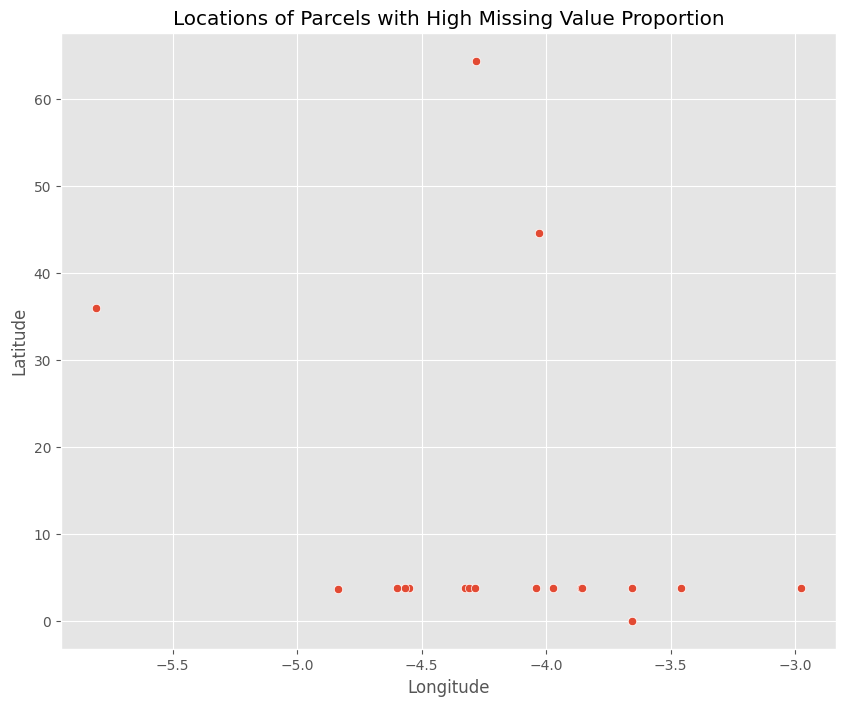

Parcels with High Missing Value Proportion:
           codparcela  missing_value_proportion
3050  021-00003-00-00                  1.000000
23       001-00006-04                  1.000000
496   003-00054-00-00                  1.000000
3052  021-00003-07-00                  1.000000
2946  019-00104-00-00                  1.000000
2155  012-00091-01-01                  1.000000
1296  007-00073-00-00                  1.000000
4155  042-00067-00-00                  1.000000
4436     055-00045-01                  1.000000
1375  007-00638-02-00                  1.000000
1320  007-00125-00-00                  1.000000
4499     059-00110-02                  1.000000
312   002-00094-00-00                  1.000000
3239     023-00031-01                  1.000000
822   005-00001-03-21                  1.000000
2190  012-00332-00-30                  1.000000
2188     012-00328-00                  1.000000
912   005-00079-05-00                  1.000000
1743     009-00255-02                  0.314

In [20]:
# Calculate the proportion of missing values for each "codparcela"
missing_values_by_parcel = meteo.groupby('codparcela')['valor'].apply(lambda x: x.isnull().mean()).reset_index(name='missing_value_proportion')

# Sort the DataFrame by missing value proportion in descending order
missing_values_by_parcel_sorted = missing_values_by_parcel.sort_values(by='missing_value_proportion', ascending=False)

# Identify "codparcela"s with a high percentage of missing values (e.g., > 0.3)
high_missing_value_parcel = missing_values_by_parcel_sorted[missing_values_by_parcel_sorted['missing_value_proportion'] > 0.3]

# Plot the locations of high missing value parcels in a scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='lon', y='lat', data=meteo[meteo['codparcela'].isin(high_missing_value_parcel['codparcela'])])
plt.title('Locations of Parcels with High Missing Value Proportion')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Print "codparcela"s with high missing value proportion and their missing value proportions
print("Parcels with High Missing Value Proportion:")
print(high_missing_value_parcel)

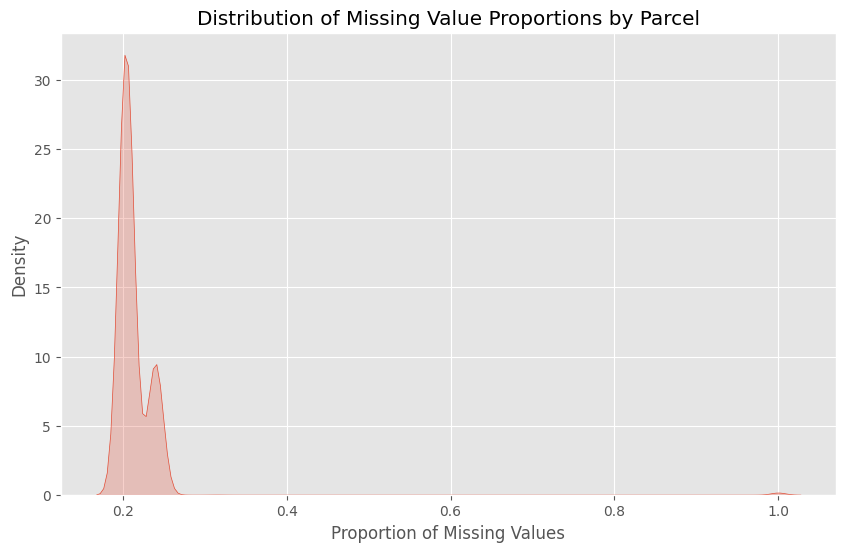

In [15]:
# Plot the distribution of missing value proportions using a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(missing_values_by_parcel['missing_value_proportion'], fill=True)
plt.title('Distribution of Missing Value Proportions by Parcel')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Density')
plt.show()

Almost all codparcelas have a 20% missing value proportion. As we saw previously,\
the SSM indice has a >80% missing value proportion and is the indice category with\
the highest representation. This high missing value proportion could be because\
of the SSM indice.

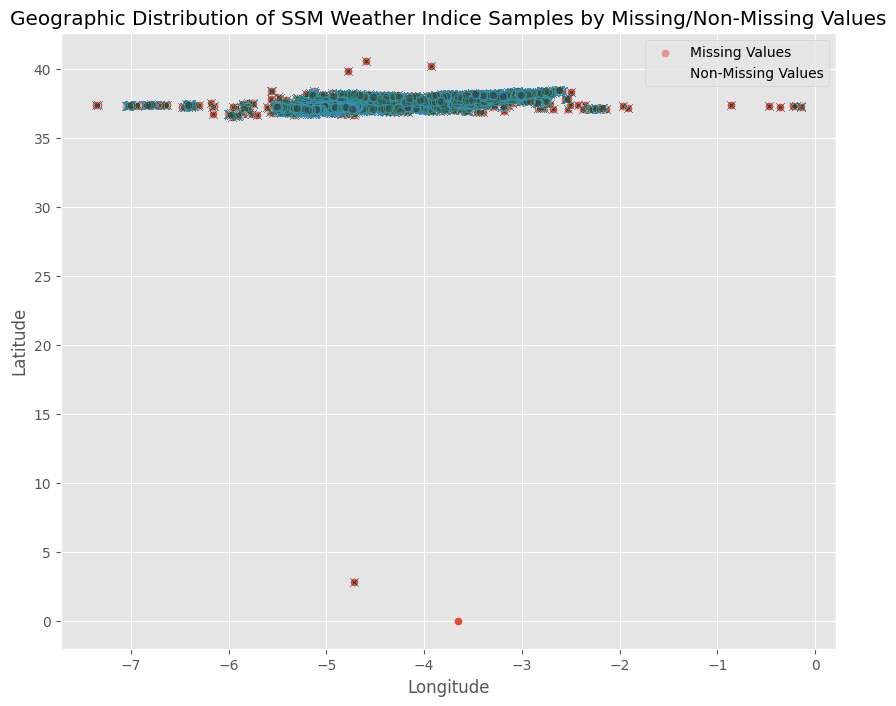

In [16]:
# Step 1: Filter out rows with missing values in 'valor' feature
aux_meteo = meteo[meteo["indice"] == "SSM"]
missing_values_df = aux_meteo[aux_meteo['valor'].isnull()]
non_missing_values_df = aux_meteo[aux_meteo['valor'].notnull()]

# Step 2: Visualize the spatial distribution
plt.figure(figsize=(10, 8))

# Plot missing values with a smaller marker size and higher transparency
sns.scatterplot(x='lon', y='lat', data=missing_values_df, alpha=0.5, marker='o', label='Missing Values')

# Plot non-missing values with a larger marker size and lower transparency
sns.scatterplot(x='lon', y='lat', data=non_missing_values_df, alpha=0.01, marker='x', label='Non-Missing Values')

plt.title('Geographic Distribution of SSM Weather Indice Samples by Missing/Non-Missing Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)  # Add grid to differentiate overlapping points
plt.show()

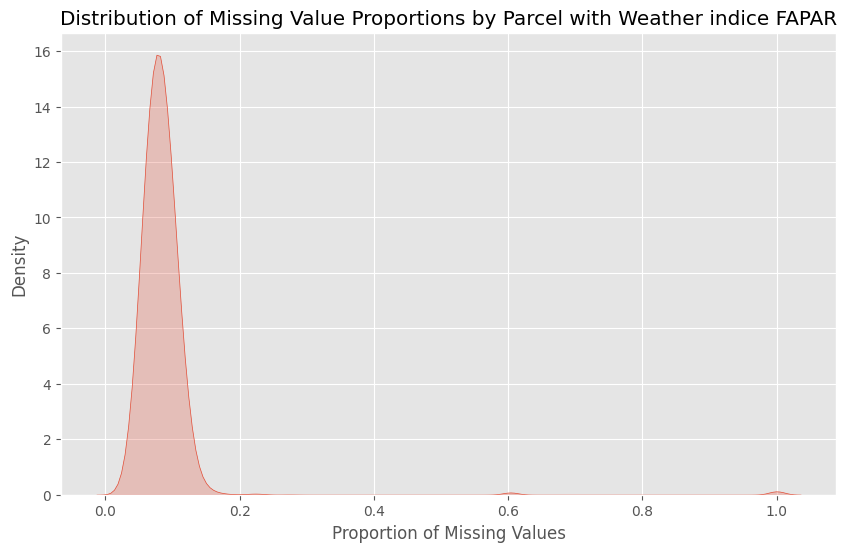

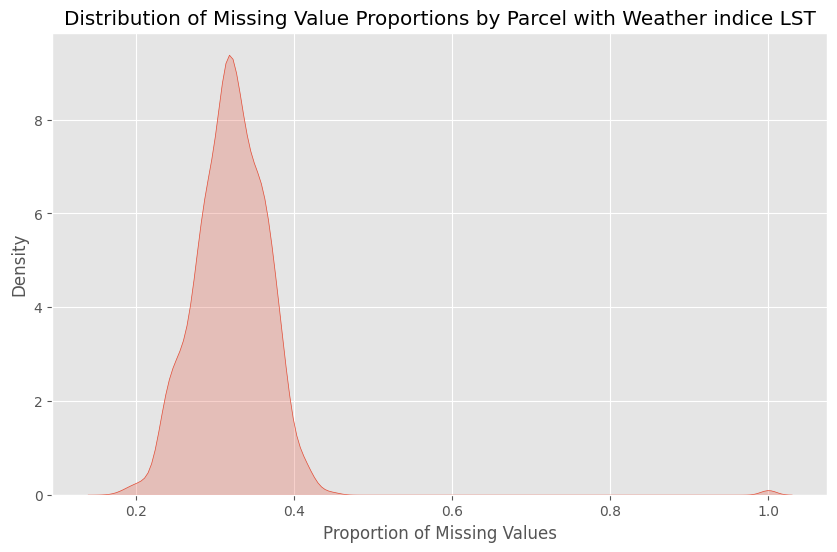

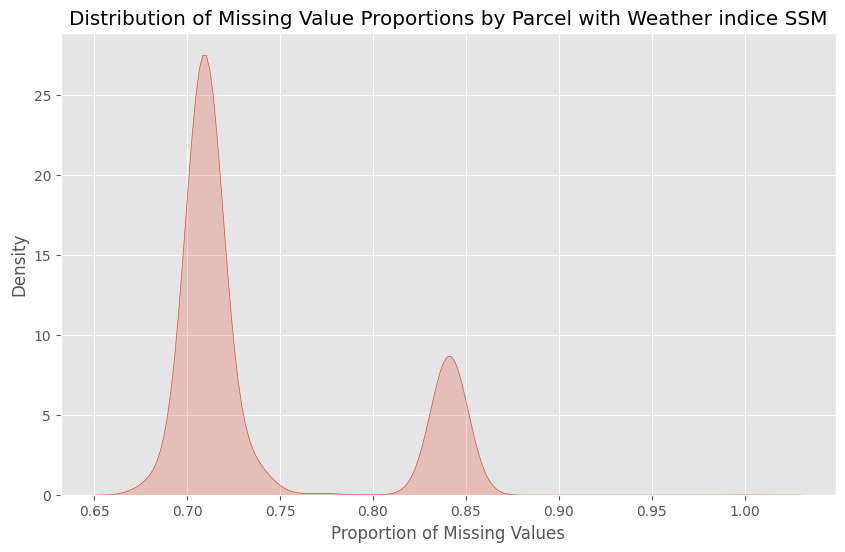

In [29]:
for indice in indices_with_nans:
    # Calculate the proportion of missing values for each "codparcela"
    missing_values_by_parcel = meteo[meteo["indice"] == indice].groupby('codparcela')['valor'].apply(lambda x: x.isnull().mean()).reset_index(name='missing_value_proportion')

    # Plot the distribution of missing value proportions using a KDE plot
    plt.figure(figsize=(10, 6))
    sns.kdeplot(missing_values_by_parcel['missing_value_proportion'], fill=True)
    plt.title(f'Distribution of Missing Value Proportions by Parcel with Weather indice {indice}')
    plt.xlabel('Proportion of Missing Values')
    plt.ylabel('Density')
    plt.show()

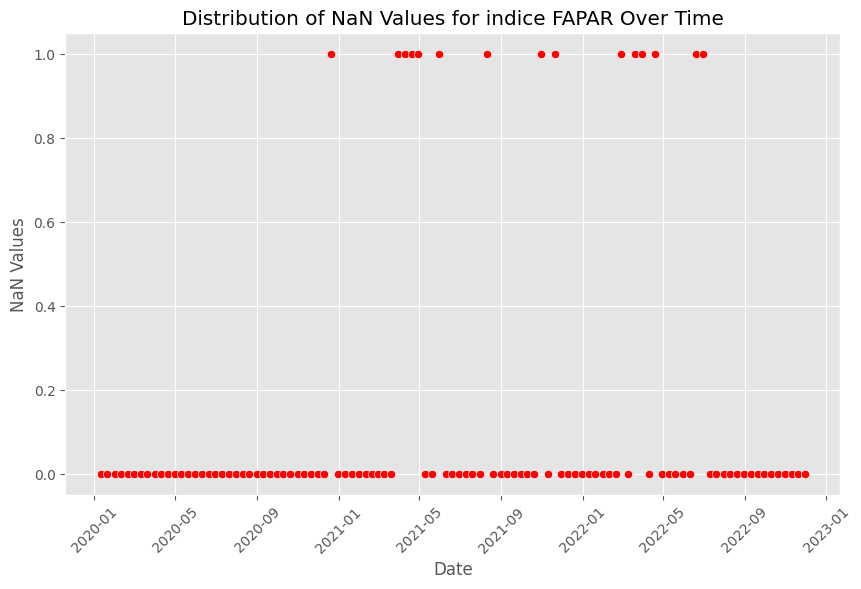

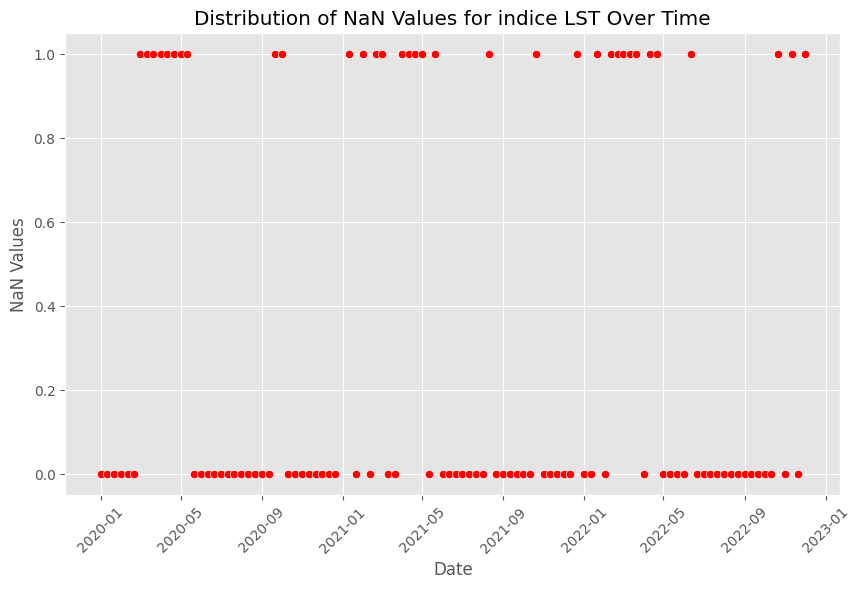

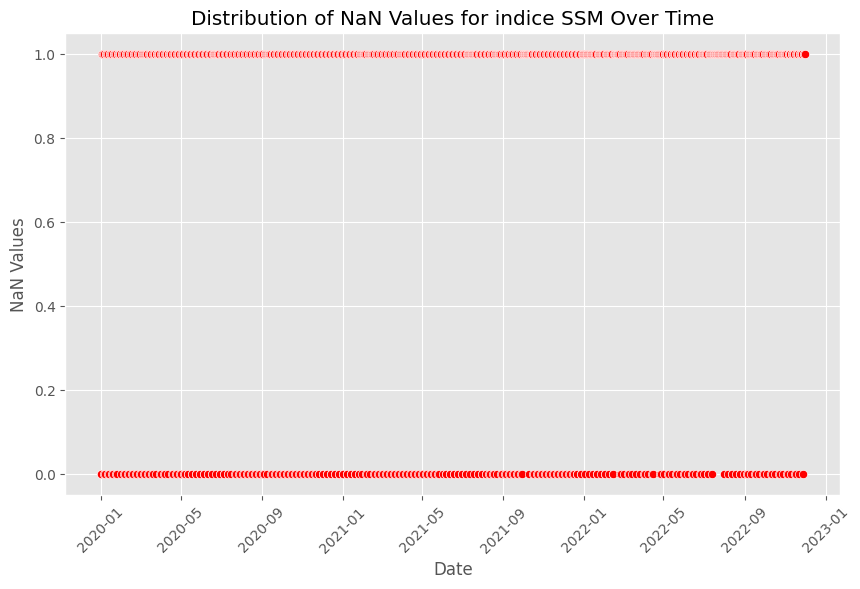

In [46]:
date_filter = (meteo['fecha'] >= '2020-01-01') & (meteo['fecha'] <= '2022-12-01')
parcela_filter = (meteo["codparcela"] == "023-00109-00-00")
for indice in indices_with_nans:
    ssm_filter = (meteo["indice"] == indice)
    ssm_parcela_data = meteo[date_filter & ssm_filter & parcela_filter]

    # Plot NaN values over time using Seaborn scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=ssm_parcela_data, x='fecha', y=ssm_parcela_data['valor'].isnull(), color='red', marker='o')
    plt.title(f'Distribution of NaN Values for indice {indice} Over Time')
    plt.xlabel('Date')
    plt.ylabel('NaN Values')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

In [27]:
ssm_parcela_data.head(50)

fecha       codparcela        lat       lon indice  valor
879132  2018-01-01  023-00109-00-00  37.146121 -2.769372    SSM    NaN
883962  2018-01-02  023-00109-00-00  37.146121 -2.769372    SSM    NaN
888792  2018-01-03  023-00109-00-00  37.146121 -2.769372    SSM    NaN
893622  2018-01-04  023-00109-00-00  37.146121 -2.769372    SSM    NaN
898452  2018-01-05  023-00109-00-00  37.146121 -2.769372    SSM   14.5
903282  2018-01-06  023-00109-00-00  37.146121 -2.769372    SSM    2.0
908112  2018-01-07  023-00109-00-00  37.146121 -2.769372    SSM    NaN
912942  2018-01-08  023-00109-00-00  37.146121 -2.769372    SSM    NaN
917772  2018-01-09  023-00109-00-00  37.146121 -2.769372    SSM    NaN
922602  2018-01-10  023-00109-00-00  37.146121 -2.769372    SSM    NaN
927432  2018-01-11  023-00109-00-00  37.146121 -2.769372    SSM   37.0
932262  2018-01-12  023-00109-00-00  37.146121 -2.769372    SSM    4.5
937092  2018-01-13  023-00109-00-00  37.146121 -2.769372    SSM    NaN
941922  2018-01-14  023-00109-00-00  37.146121 -2.769372    SSM    NaN
946752  2018-01-15  023-00109-00-00  37.146121 -2.769372    SSM    NaN
951582  2018-01-16  023-00109-00-00  37.146121 -2.769372    SSM    NaN
956412  2018-01-17  023-00109-00-00  37.146121 -2.769372    SSM   15.5
961242  2018-01-18  023-00109-00-00  37.146121 -2.769372    SSM    0.0
966072  2018-01-19  023-00109-00-00  37.146121 -2.769372    SSM    NaN
970902  2018-01-20  023-00109-00-00  37.146121 -2.769372    SSM    NaN
975732  2018-01-21  023-00109-00-00  37.146121 -2.769372    SSM    NaN
980562  2018-01-22  023-00109-00-00  37.146121 -2.769372    SSM    NaN
985392  2018-01-23  023-00109-00-00  37.146121 -2.769372    SSM   21.0
990222  2018-01-24  023-00109-00-00  37.146121 -2.769372    SSM    0.0
995052  2018-01-25  023-00109-00-00  37.146121 -2.769372    SSM    NaN
999882  2018-01-26  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1004712 2018-01-27  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1009542 2018-01-28  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1014372 2018-01-30  023-00109-00-00  37.146121 -2.769372    SSM    0.0
1019202 2018-01-31  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1024032 2018-02-01  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1028862 2018-02-02  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1033692 2018-02-03  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1038522 2018-02-04  023-00109-00-00  37.146121 -2.769372    SSM   88.0
1043352 2018-02-05  023-00109-00-00  37.146121 -2.769372    SSM   20.0
1048182 2018-02-06  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1053012 2018-02-07  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1057842 2018-02-08  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1062672 2018-02-09  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1067502 2018-02-10  023-00109-00-00  37.146121 -2.769372    SSM   10.0
1072332 2018-02-11  023-00109-00-00  37.146121 -2.769372    SSM    0.0
1077162 2018-02-12  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1081992 2018-02-13  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1086822 2018-02-14  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1091652 2018-02-15  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1096482 2018-02-16  023-00109-00-00  37.146121 -2.769372    SSM   21.0
1101312 2018-02-17  023-00109-00-00  37.146121 -2.769372    SSM    3.0
1106142 2018-02-18  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1110972 2018-02-20  023-00109-00-00  37.146121 -2.769372    SSM    NaN
1115802 2018-02-21  023-00109-00-00  37.146121 -2.769372    SSM    NaN

The SSM weather indice has a frequency of 1 days, however, the valid values\
have a frequency of 6 days. Thus, we can delete the nan values of the ssm indice.

Insights:
- From these plots and previous ones, we can confirm that codparcelas with\
  latitude < 10 and latitude > 43, most of them ONLY have missing values. We\
  can DELETE them, as they don't contain useful data.
- Almost all codparcela's have a missing value proportion of 20% of their samples.
- The majority of the distribution of missing values proportion for each codparcela\
  of the "SSM" weather index is in 70% and 84%, which is extremely high. The\
  reason is that the SSM weather indice has a frequency of 1 day, however, the\
  valid value have a frequency of 6 days, with all the others being NaNs. Thus,\
  we can delete the nan values of the SSM indice. MNAR.
- For FAPAR and LST, their missing values are MAR.

## 2. Numerical variables

In [18]:
numerical_features = meteo.select_dtypes(include=np.number).columns.tolist()
print("Numerical features:", numerical_features)

print("Number of numerical variables:", len(numerical_features))

meteo[numerical_features].head()

Numerical features: ['lat', 'lon', 'valor']
Number of numerical variables: 3


lat       lon  valor
9529662  37.146121 -2.769372  255.0
9529663  37.140687 -2.772991  127.0
9529664  37.157344 -2.816261   55.0
9529665  37.146910 -2.795299  255.0
9529666  37.205017 -1.919212   33.0

## 3. Distribution of numerical values

In [20]:
# splitted_indices = ["ndvi", "savi", "gndvi"]
# non_splitted_indices = []
# for indice, _ in indice_grp:
#     found = False
#     for x in splitted_indices:
#         if x in indice:
#             found = True
#             break
#     if found:
#         continue
#     non_splitted_indices.append(indice)
# print(splitted_indices)
# print(non_splitted_indices)

['ndvi', 'savi', 'gndvi']
['FAPAR', 'LST', 'NDVI', 'NDWI', 'SIPI', 'SSM']


In [22]:
for indice, group in indice_grp:
    print(indice)
    print(group["valor"].describe())

FAPAR
count    793345.000000
mean         35.050987
std          46.267452
min           0.000000
25%           0.268000
50%           0.464000
75%          72.000000
max         255.000000
Name: valor, dtype: float64
GNDVI
count    4.303530e+06
mean     2.237758e+34
std      4.717903e+35
min     -7.627274e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.969210e+36
Name: valor, dtype: float64
LST
count    583713.000000
mean        287.045285
std           7.070922
min         268.820007
25%         280.419983
50%         288.070007
75%         293.220001
max         302.169983
Name: valor, dtype: float64
NDVI
count    4.303530e+06
mean     1.566530e-01
std      2.288037e-01
min     -1.363401e-01
25%      0.000000e+00
50%      0.000000e+00
75%      3.575692e-01
max      9.931741e-01
Name: valor, dtype: float64
NDWI
count    4.303530e+06
mean    -1.752611e-01
std      2.461966e-01
min     -9.931741e-01
25%     -4.465753e-01
50%     -0.000000e+00
75%      0

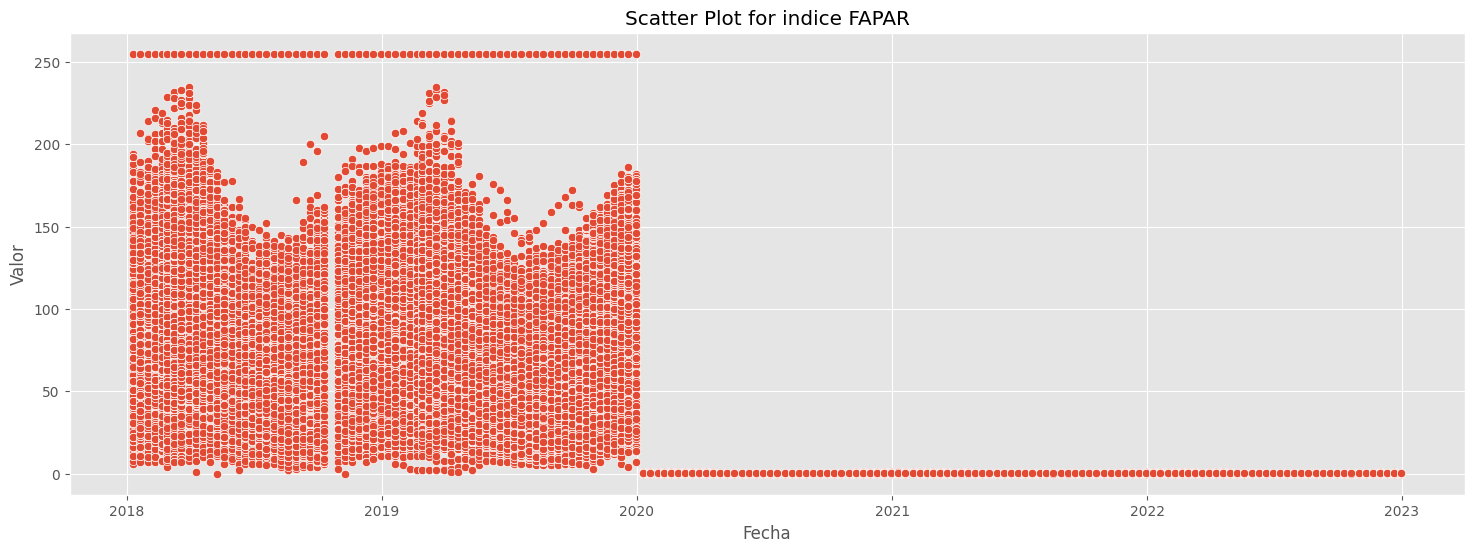

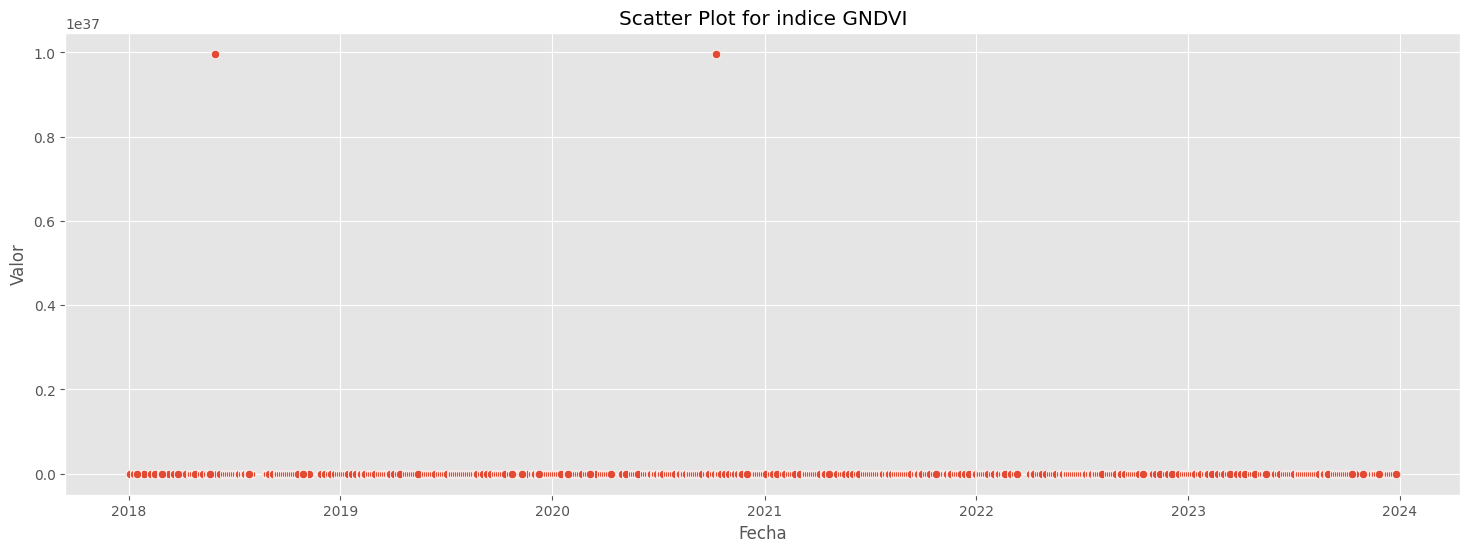

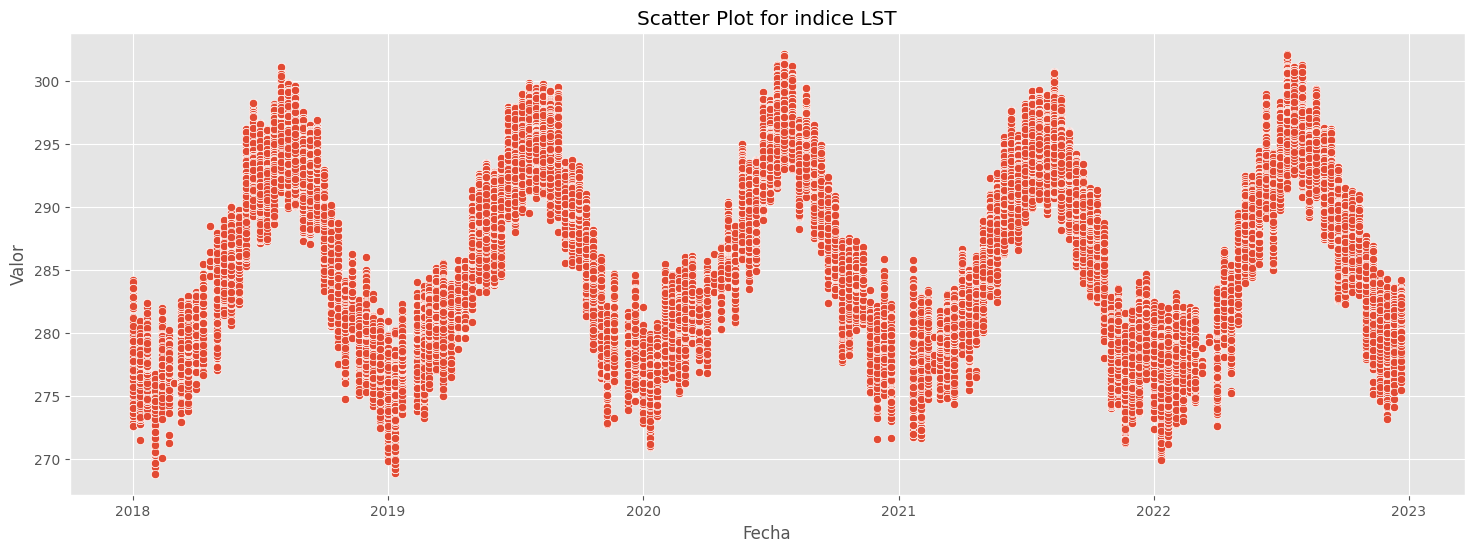

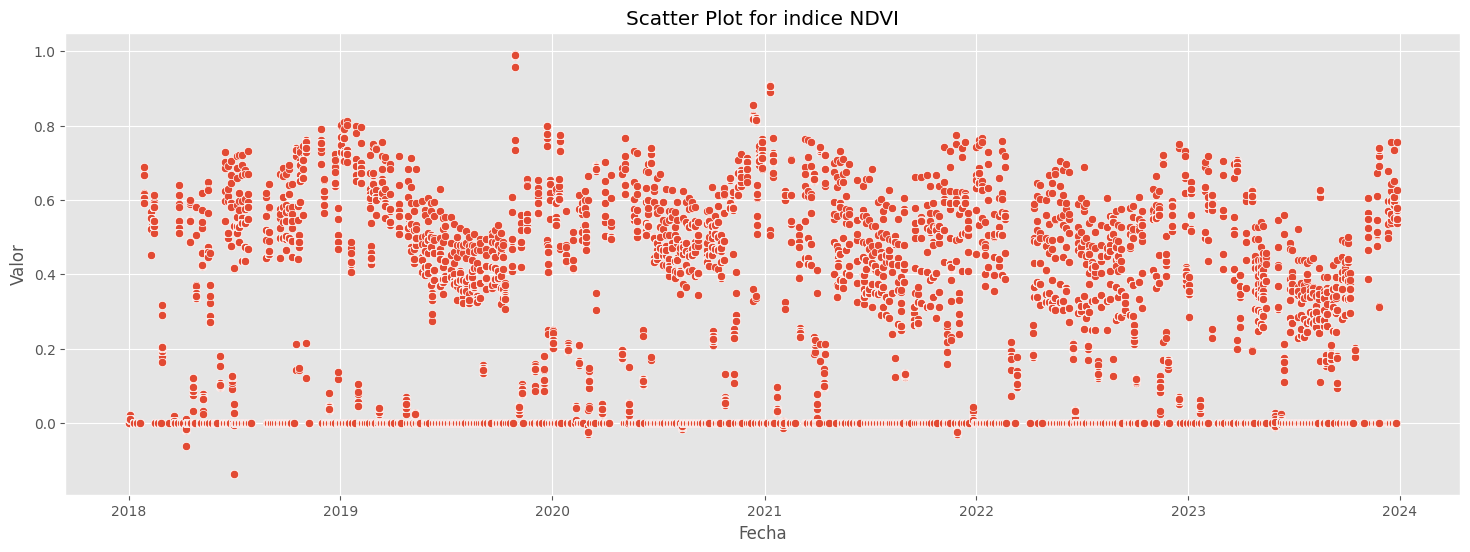

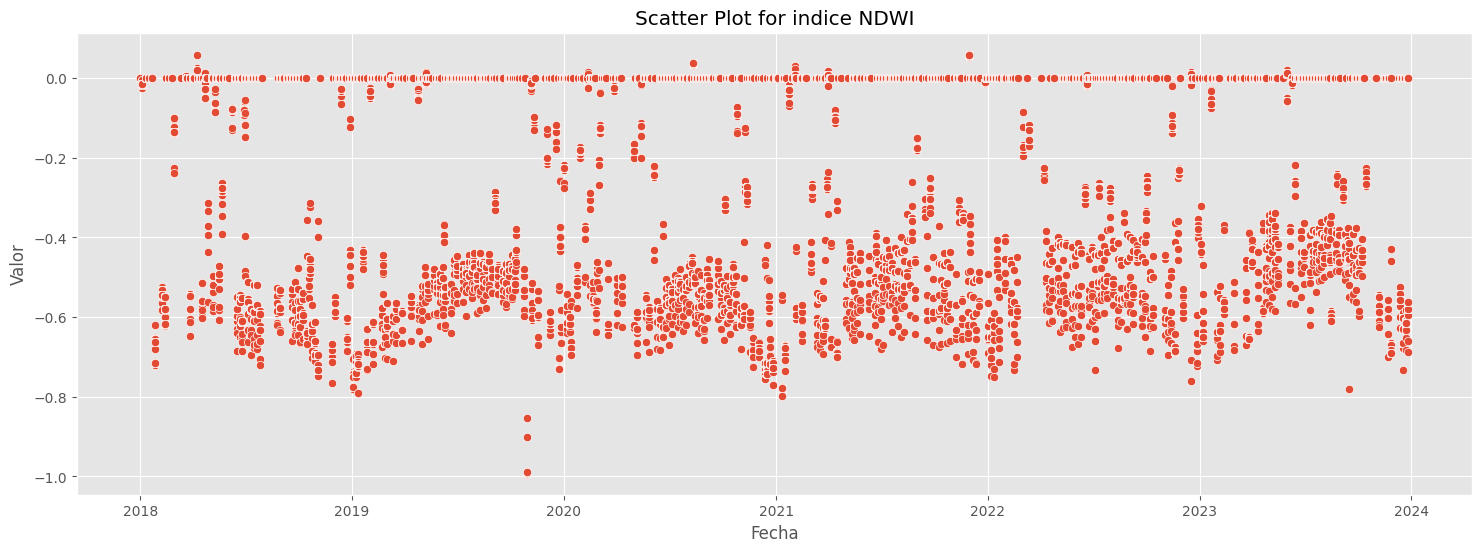

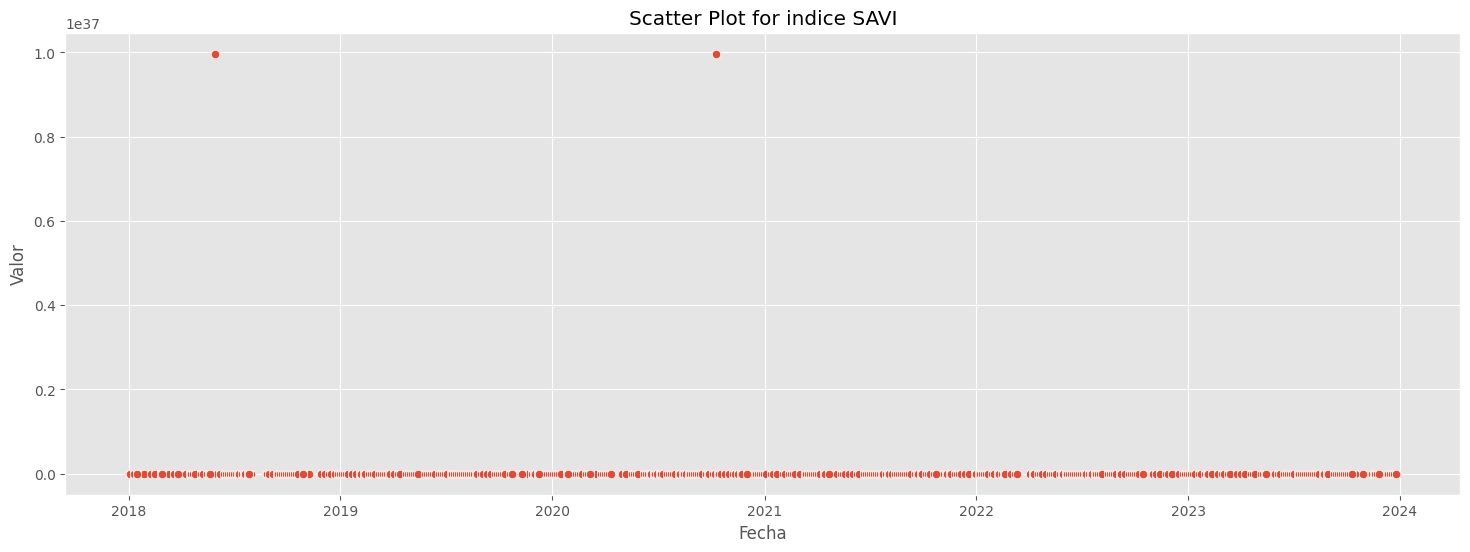

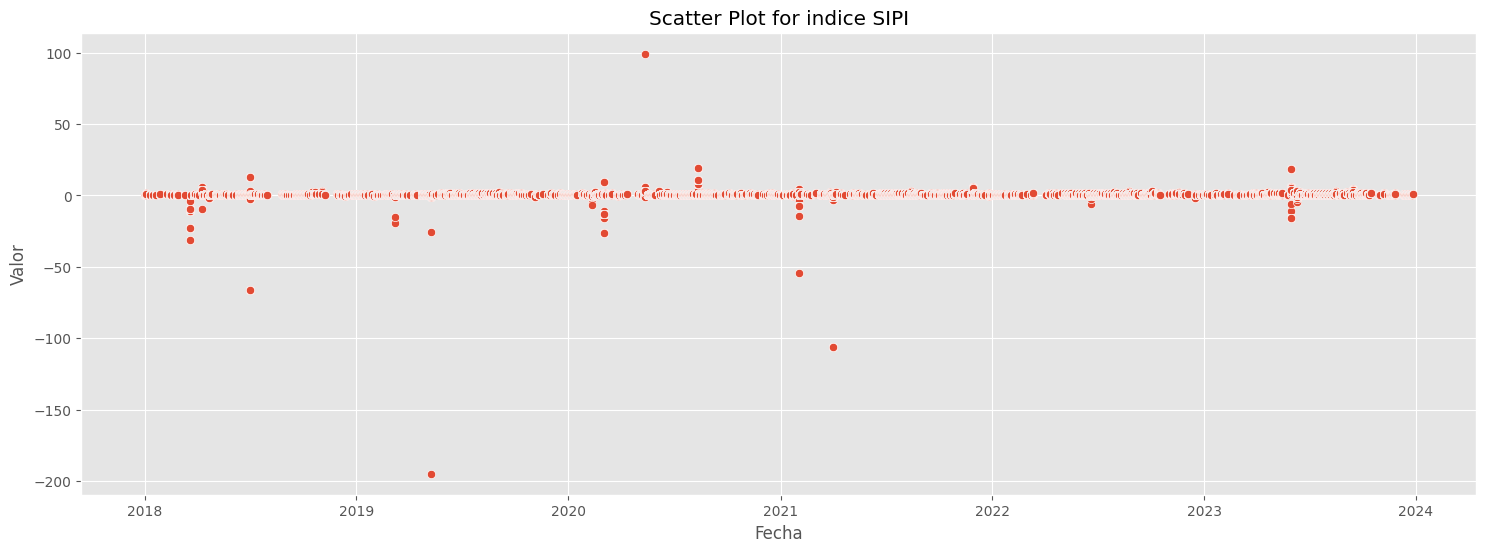

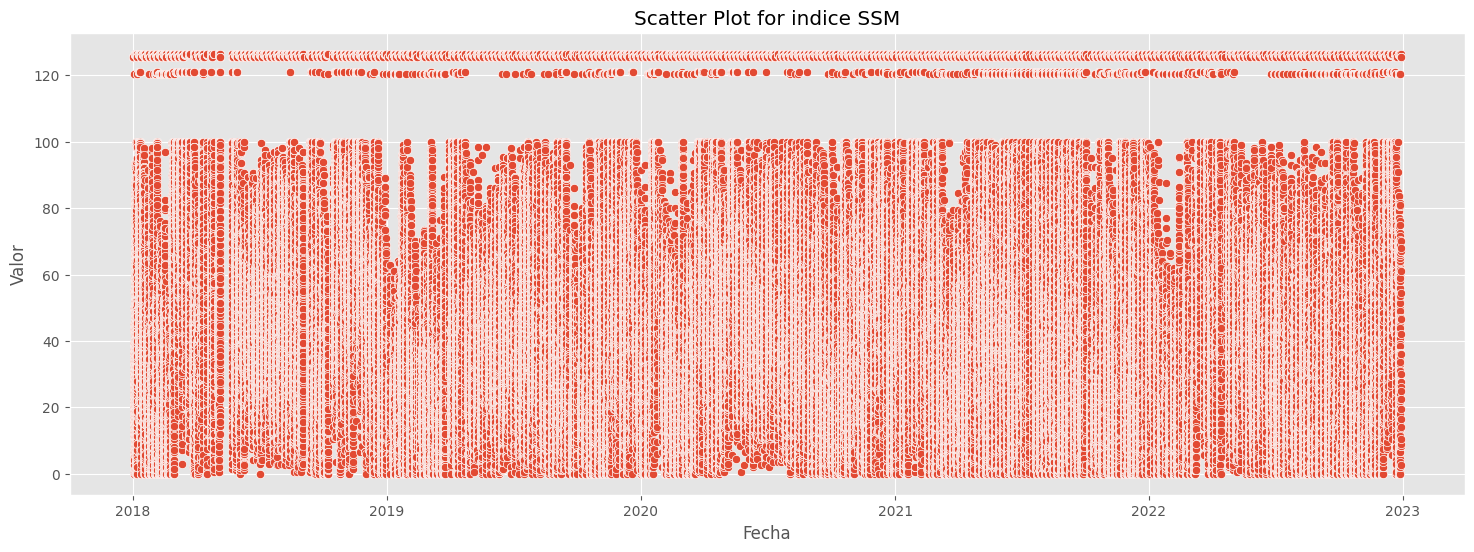

In [23]:
for indice, group in indice_grp:
    plt.figure(figsize=(18, 6))

    sns.scatterplot(data=group, x='fecha', y='valor')

    plt.title(f'Scatter Plot for indice {indice}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()

- Outliers on SAVI and GNDVI and SIPI?
- Why are there so many samples with value close to 0 in almost all indices?
- FAPAR has weird values from 2020 onwards.

Taking a look closer into a year

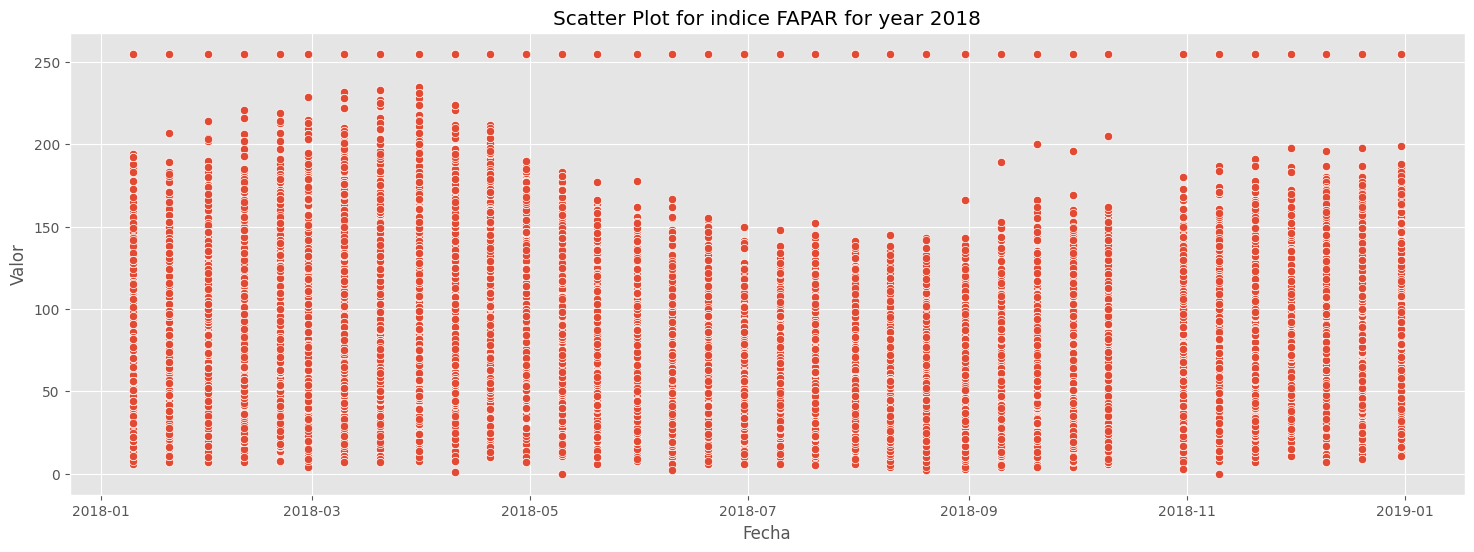

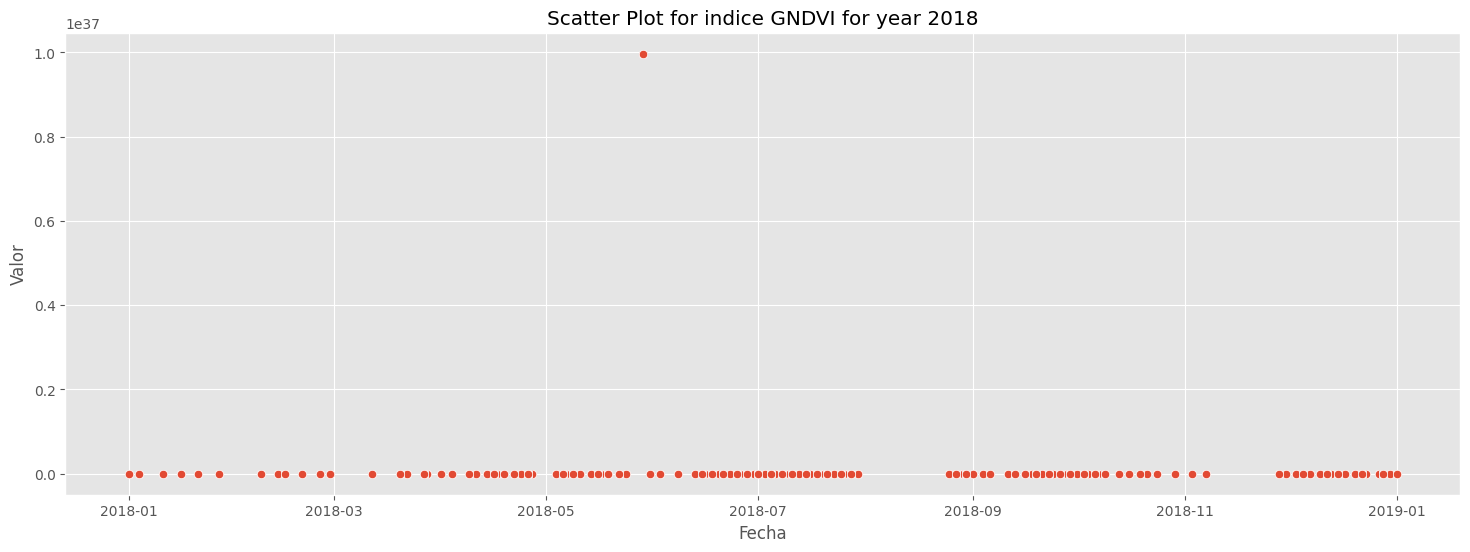

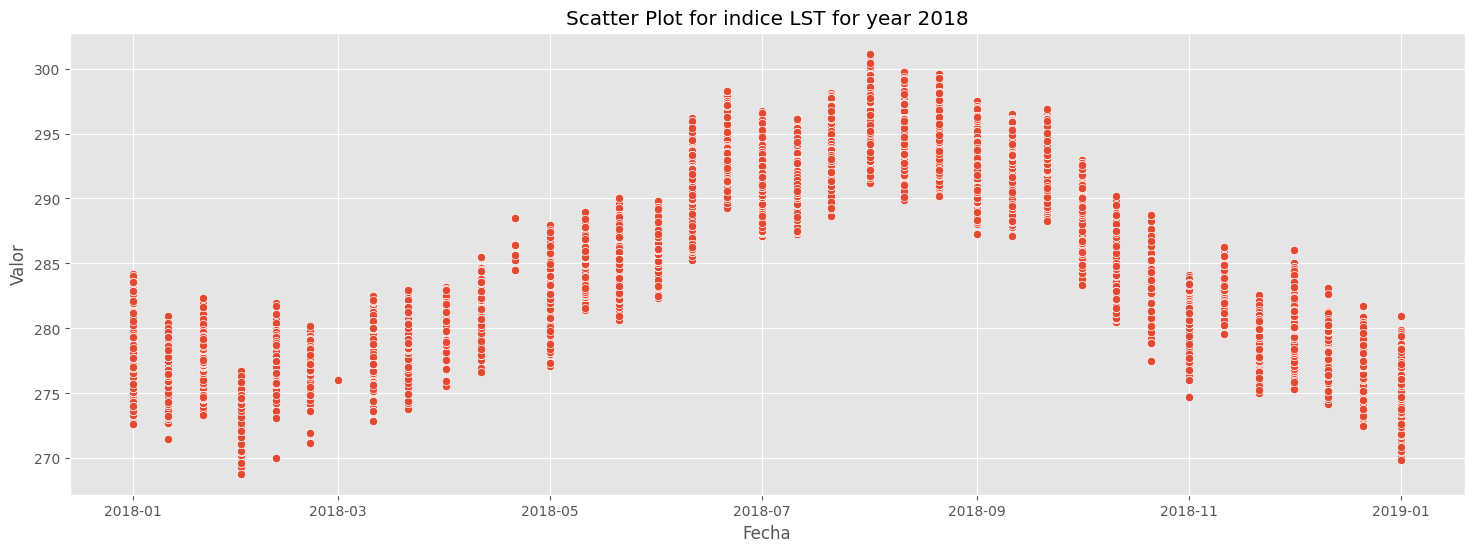

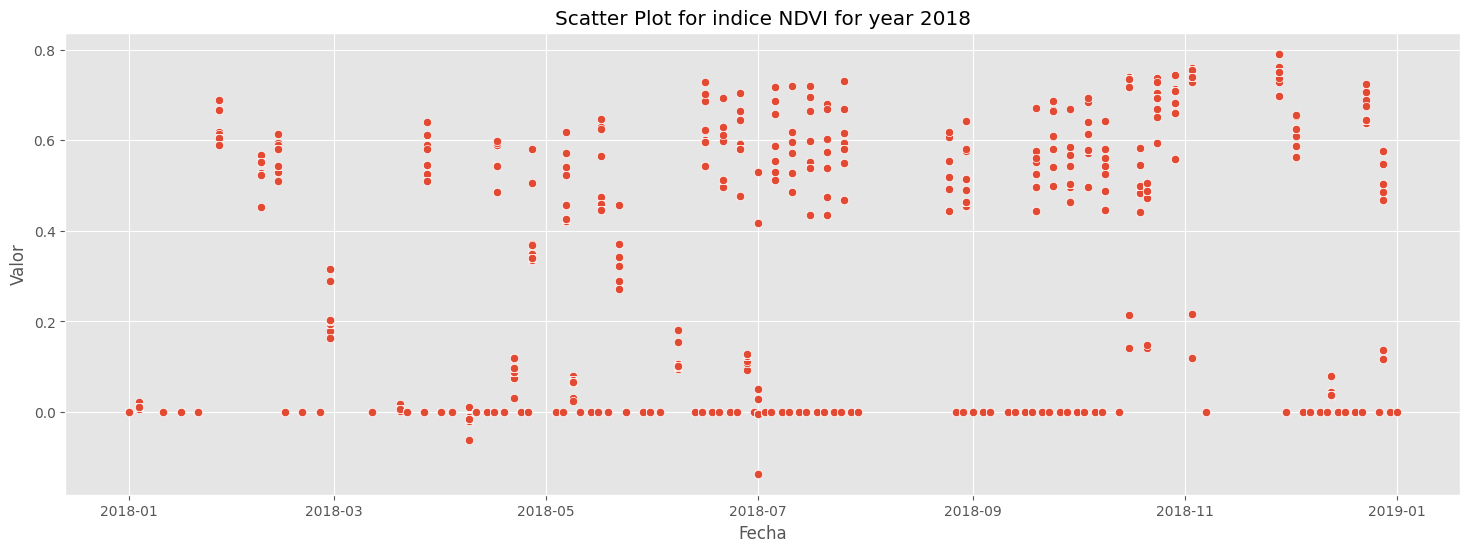

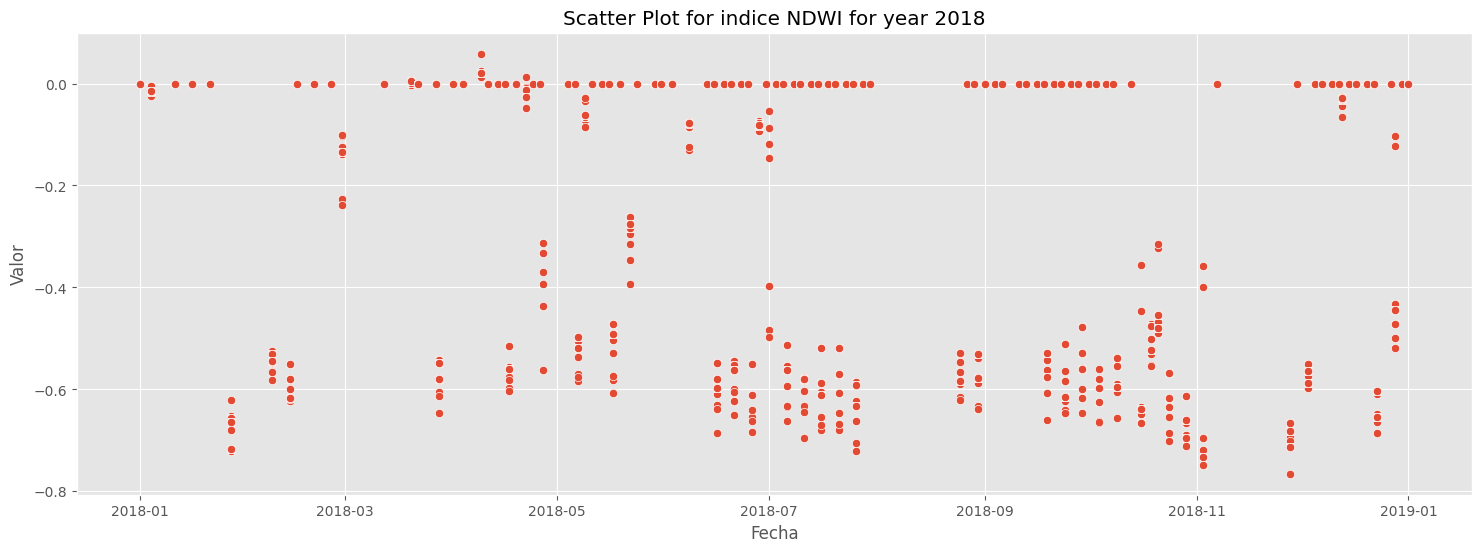

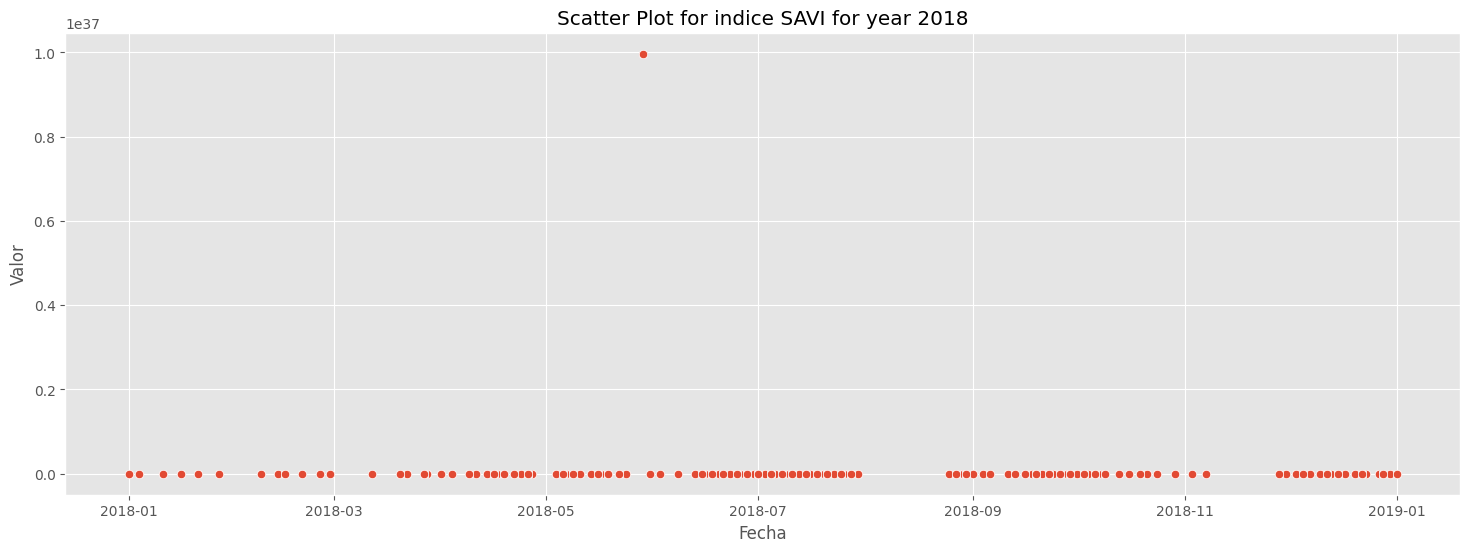

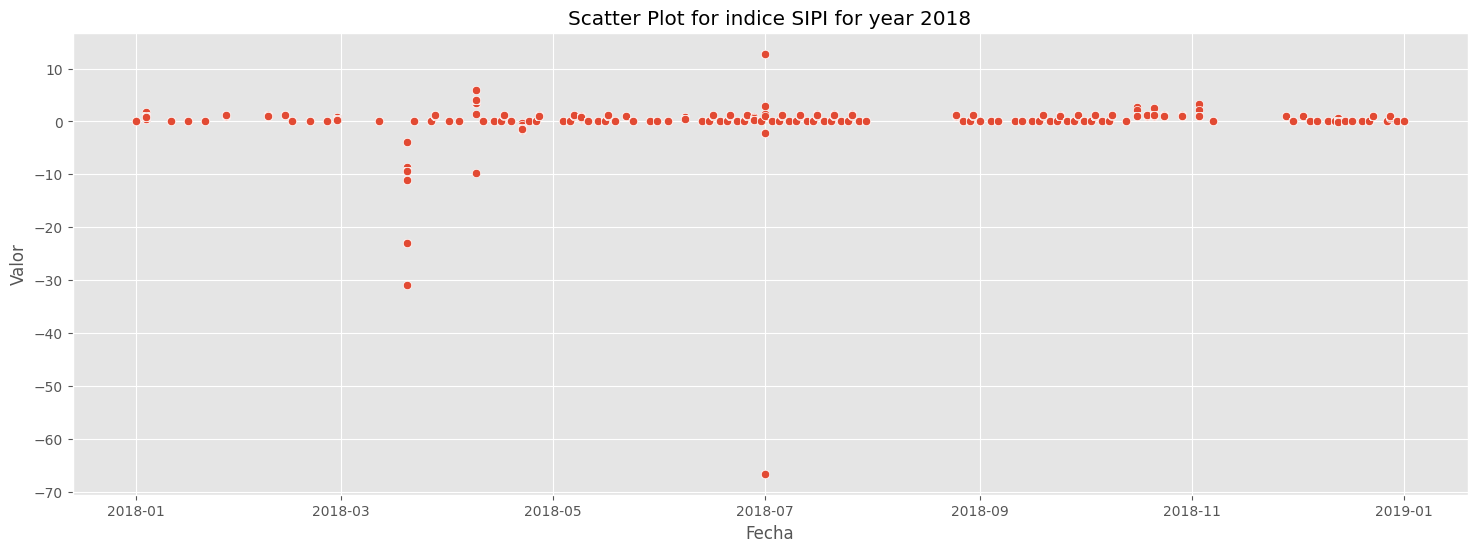

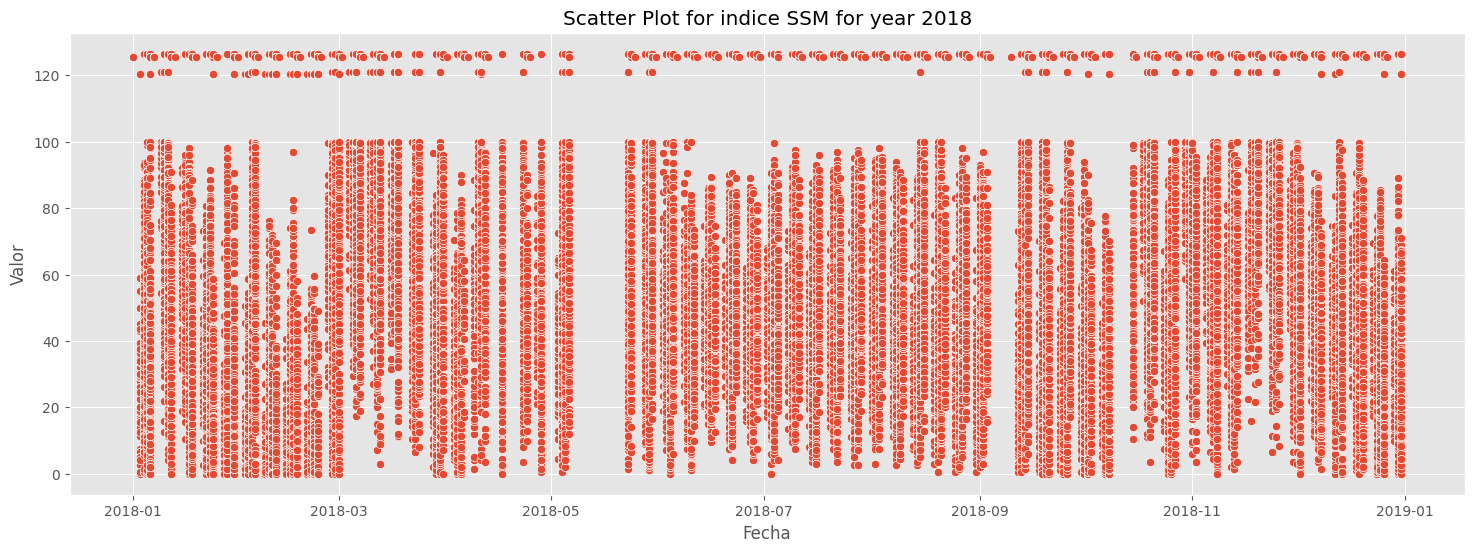

In [24]:
date_filter = (meteo['fecha'] >= '2018-01-01') & (meteo['fecha'] <= '2019-01-01')

for indice, group in meteo[date_filter].groupby("indice"):
    plt.figure(figsize=(18, 6))

    sns.scatterplot(data=group, x='fecha', y='valor')

    plt.title(f'Scatter Plot for indice {indice} for year 2018')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()

Analysing the weather indices for a particular "codparcela"

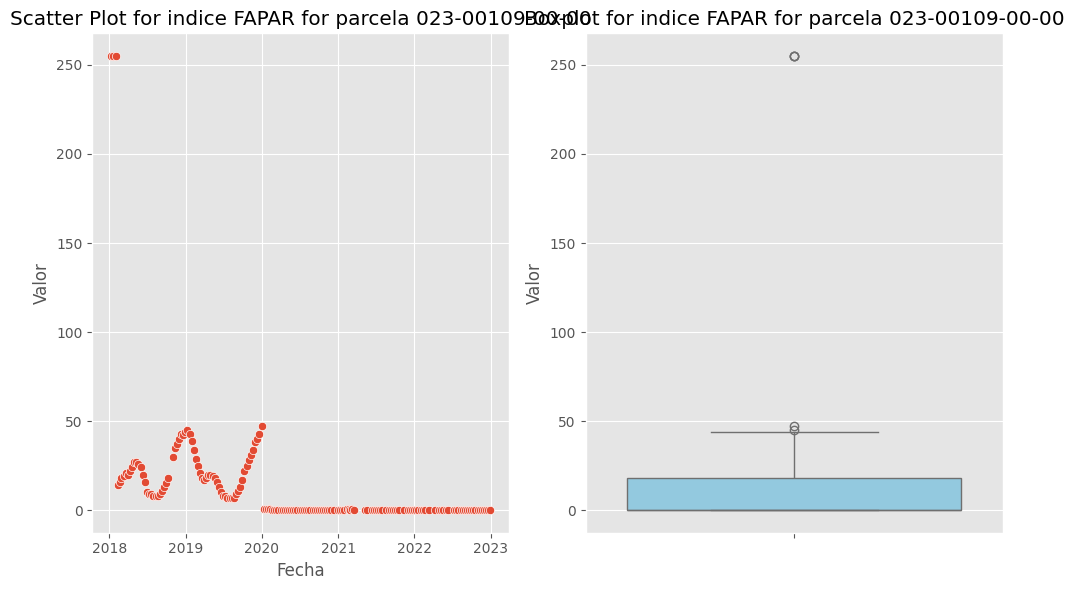

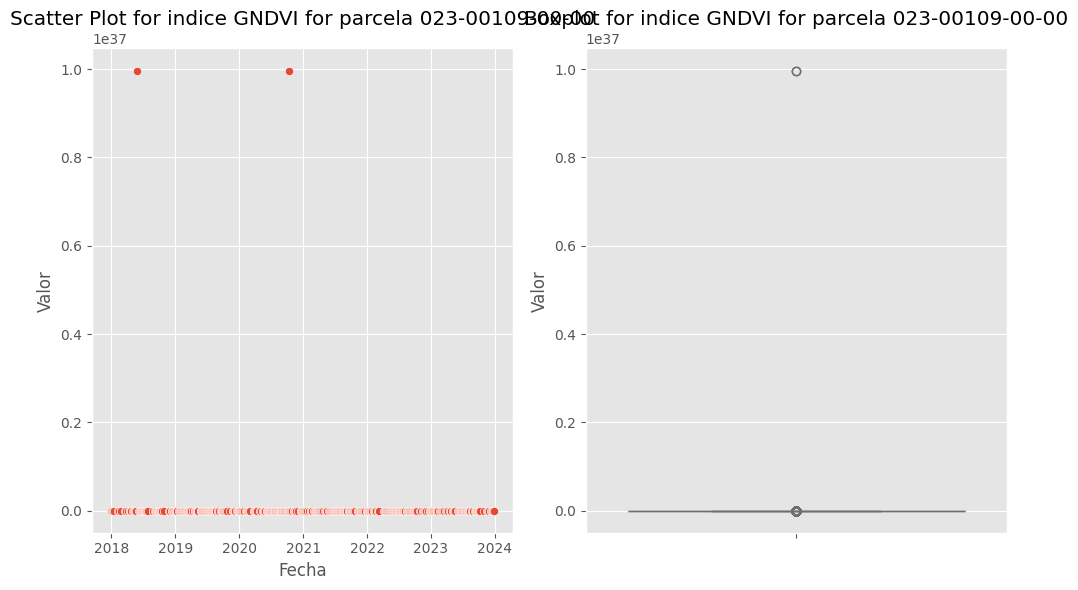

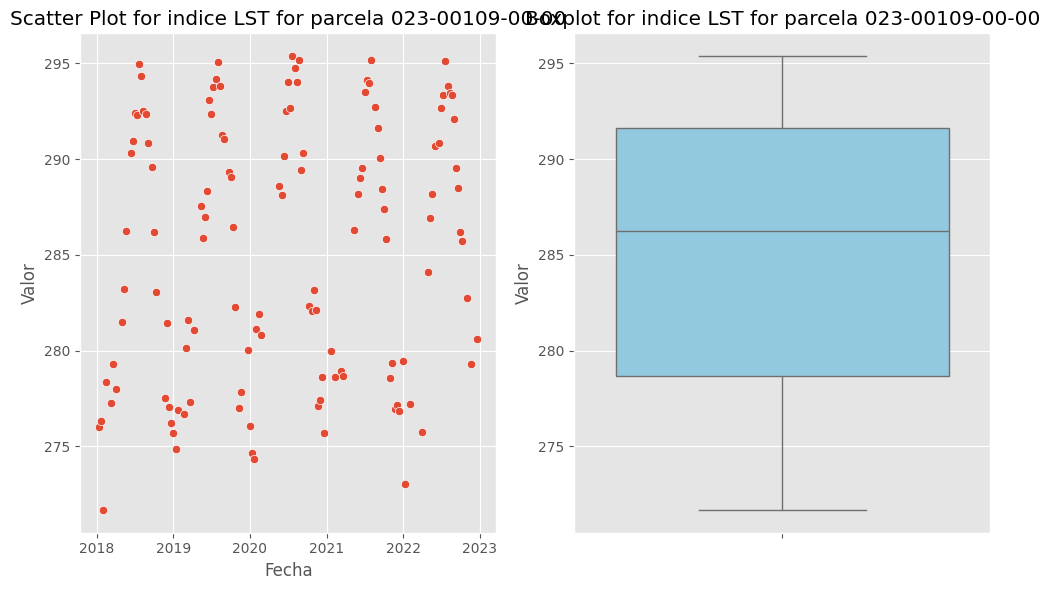

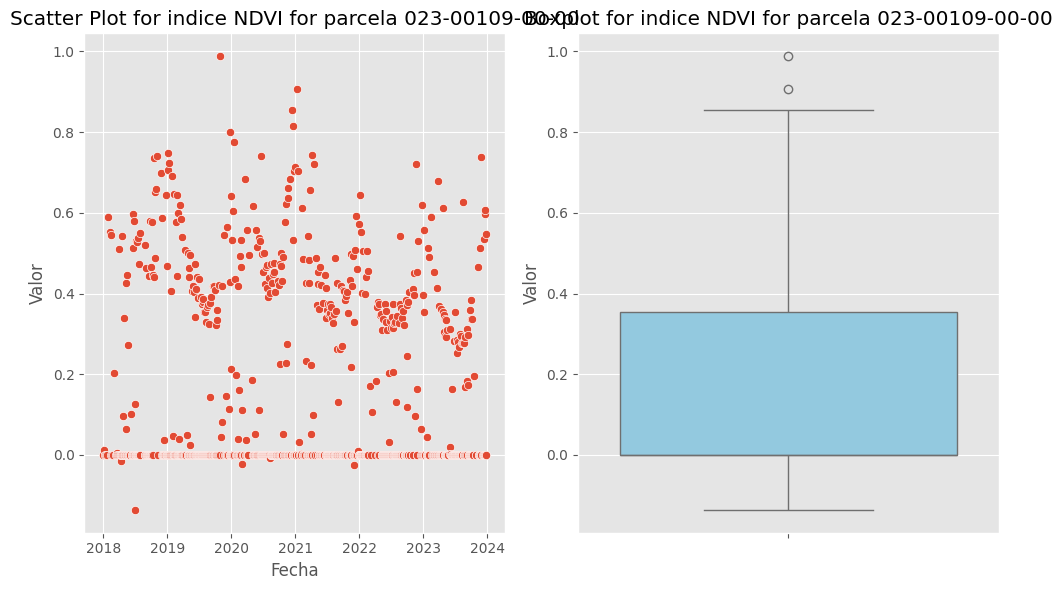

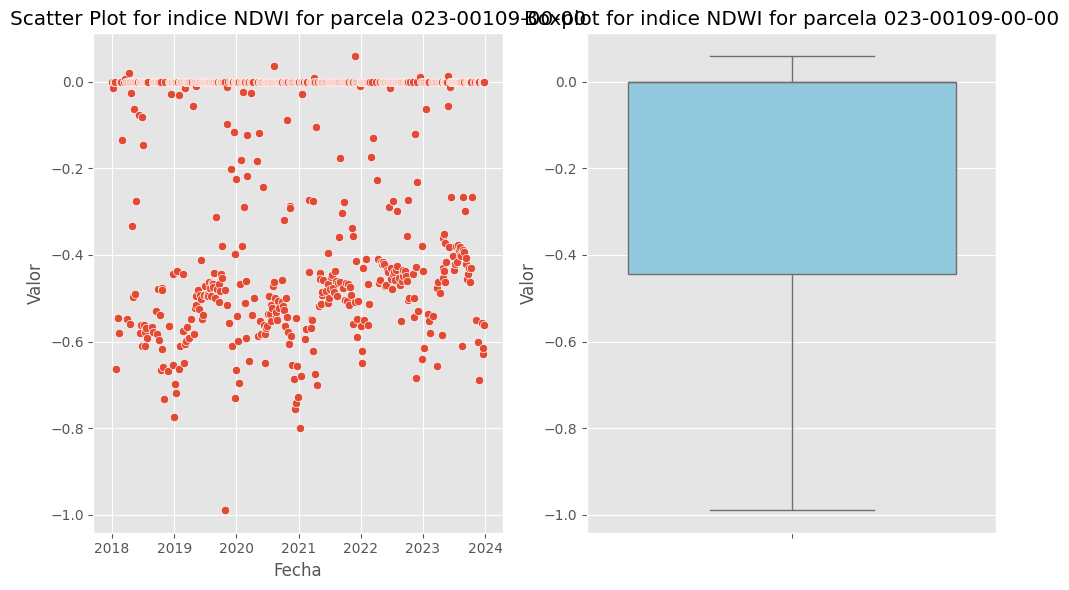

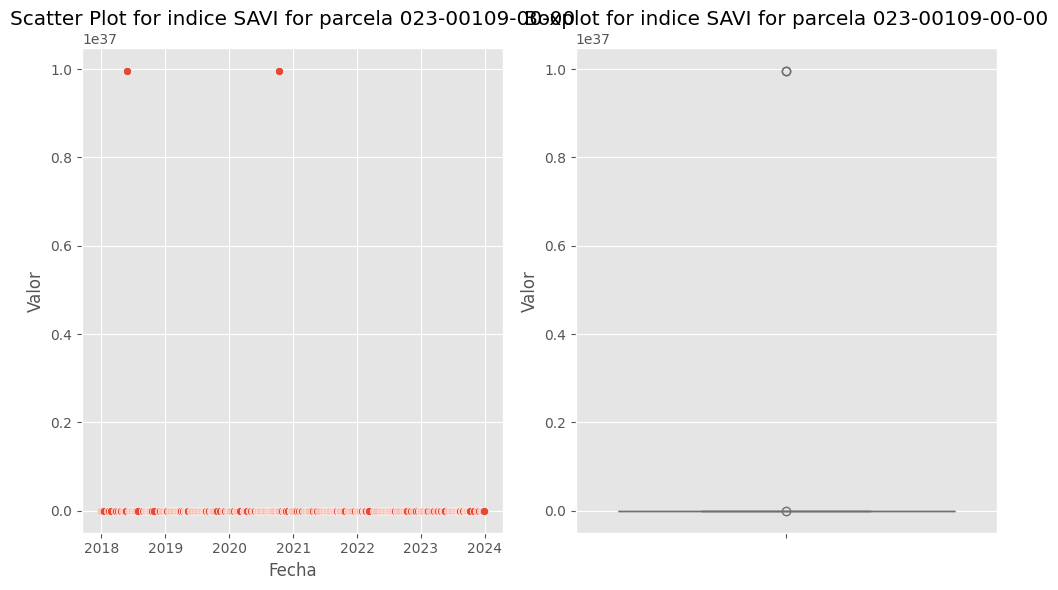

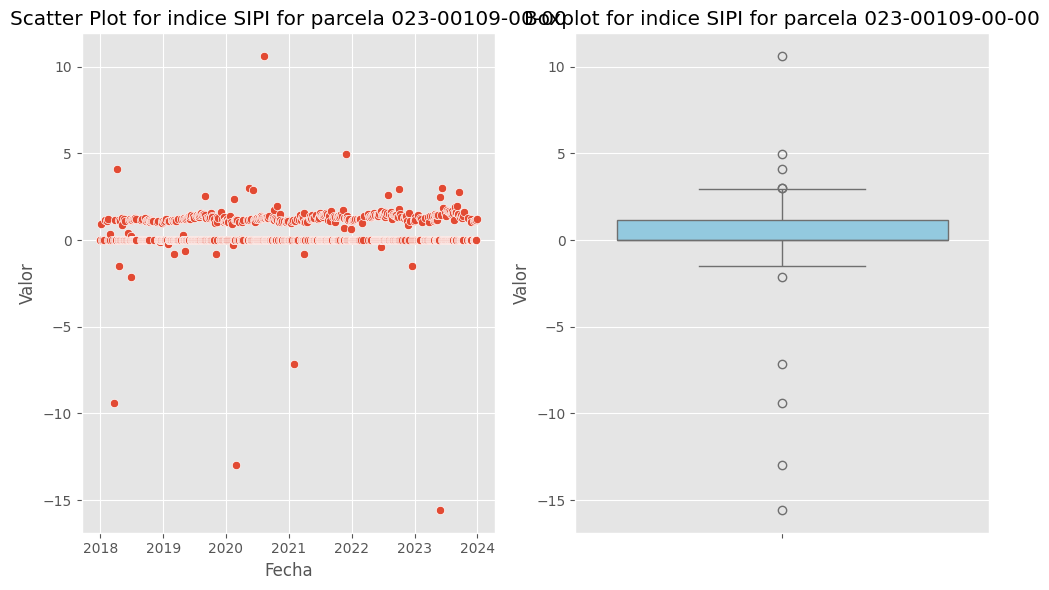

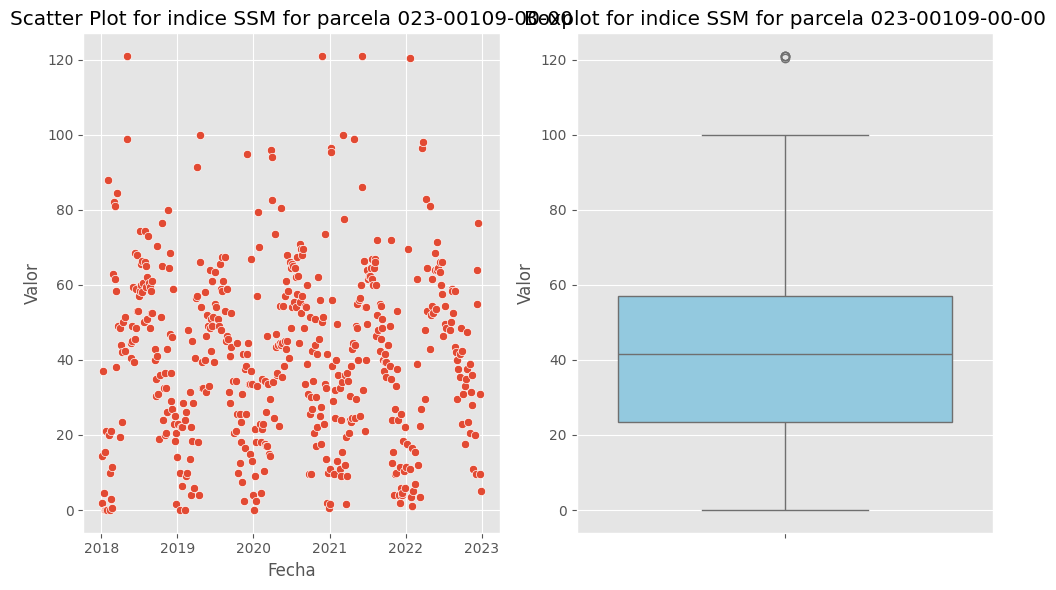

In [26]:
codparcela = "023-00109-00-00"
codparcela_filter = meteo["codparcela"] == codparcela
for indice, group in meteo[codparcela_filter].groupby("indice"):
    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)  # Create subplot for scatter plot
    sns.scatterplot(data=group, x='fecha', y='valor')
    plt.title(f'Scatter Plot for indice {indice} for parcela {codparcela}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    
    # Boxplot
    plt.subplot(1, 2, 2)  # Create subplot for boxplot
    sns.boxplot(data=group, y='valor', color='skyblue')
    plt.title(f'Boxplot for indice {indice} for parcela {codparcela}')
    plt.ylabel('Valor')
    
    plt.tight_layout()  # Adjust layout to prevent overlapping plots
    plt.show()

Insights:
- There is a clear seasonality pattern between each year for LST, NDVI, NDWI, SIPI and SSM.
- SAVI, GNDVI have outliers with value 1.0, and FAPAR with values 255.
- Weird observations:
  - Some weather indices have a lot of 0.0 values?
  - Why FAPAR have values close to 0 from 2020 onwards?

### Exploring the weather indices for a single codparcela and a year

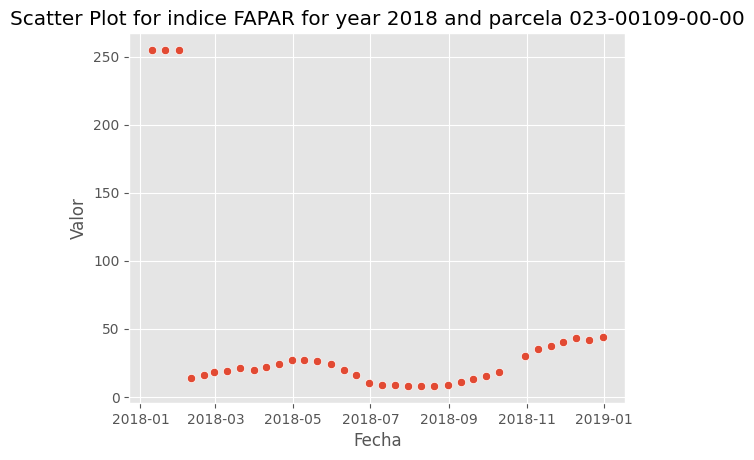

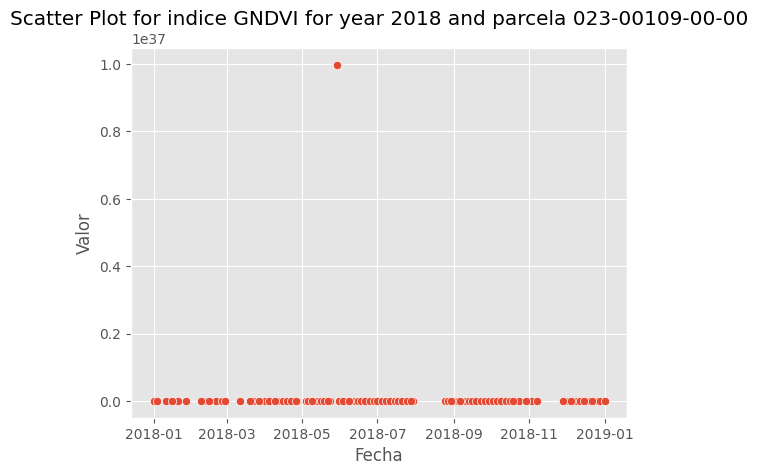

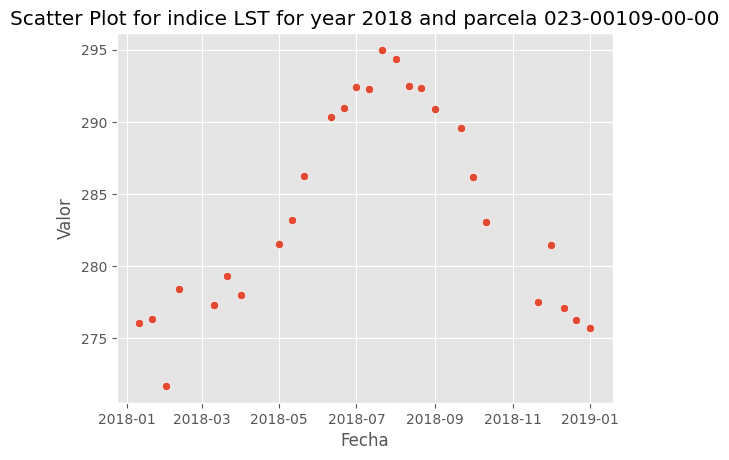

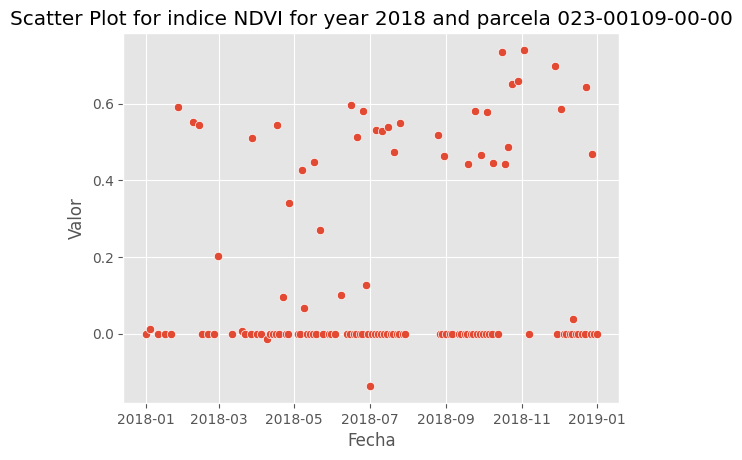

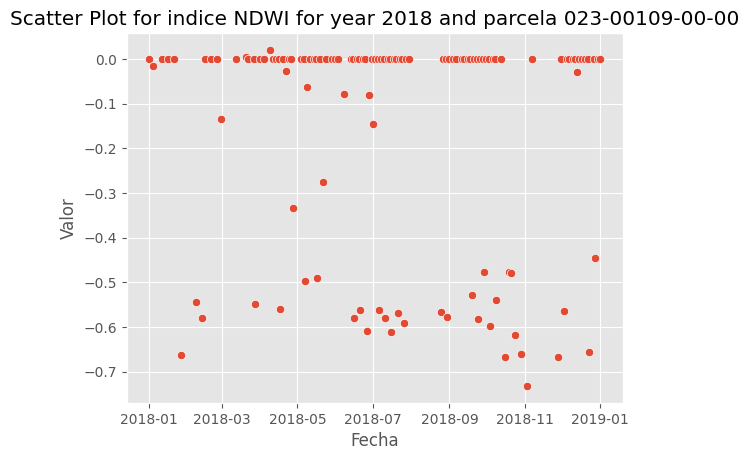

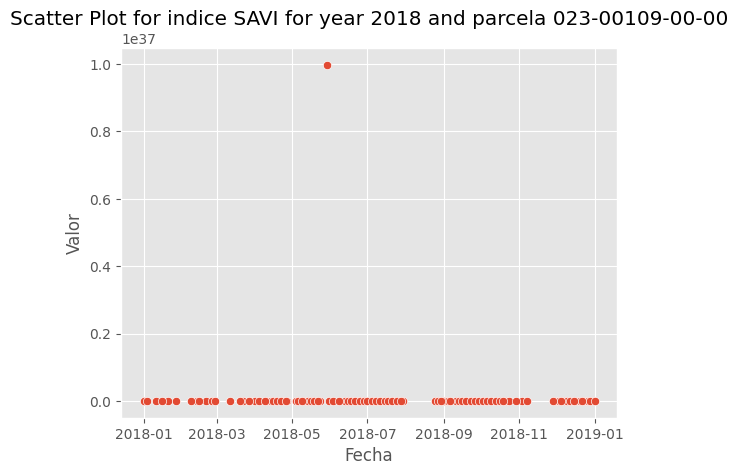

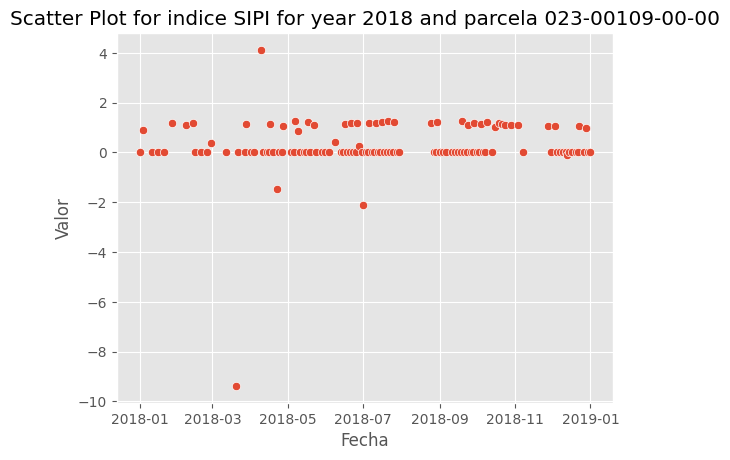

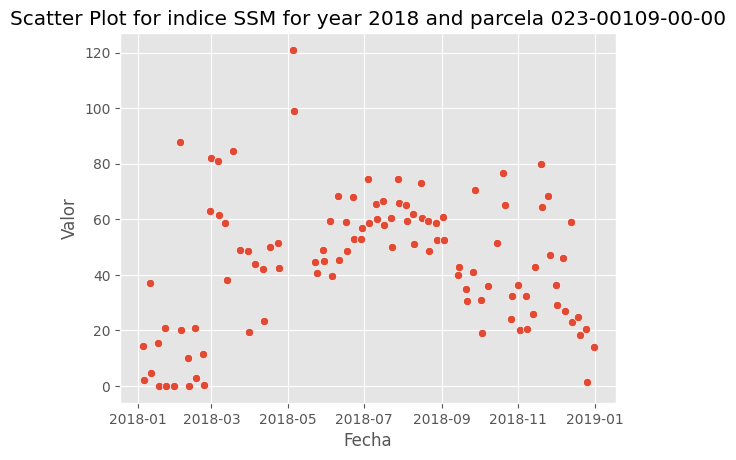

In [27]:
for indice, group in meteo[codparcela_filter & date_filter].groupby("indice"):
    plt.figure()
    
    sns.scatterplot(data=group, x='fecha', y='valor')

    plt.title(f'Scatter Plot for indice {indice} for year 2018 and parcela {codparcela}')
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.show()

### Further analysis for FAPAR indice


We saw that up until 2020, its value was between 0 and 255. However, 2020 onwards,\
its value consistently was close to 0, WHY?

In [28]:
date_filter = (meteo['fecha'] >= '2019-05-01')
codparcela_filter = (meteo["codparcela"] == "023-00109-00-00")
fapar_filter = (meteo["indice"] == "FAPAR")
meteo[date_filter & fapar_filter & codparcela_filter].head(50)

fecha       codparcela        lat       lon indice   valor
9756672 2019-05-10  023-00109-00-00  37.146121 -2.769372  FAPAR  19.000
9761502 2019-05-20  023-00109-00-00  37.146121 -2.769372  FAPAR  18.000
9766332 2019-05-31  023-00109-00-00  37.146121 -2.769372  FAPAR  16.000
9771162 2019-06-10  023-00109-00-00  37.146121 -2.769372  FAPAR  13.000
9775992 2019-06-20  023-00109-00-00  37.146121 -2.769372  FAPAR  10.000
9780822 2019-06-30  023-00109-00-00  37.146121 -2.769372  FAPAR   8.000
9785652 2019-07-10  023-00109-00-00  37.146121 -2.769372  FAPAR   8.000
9790482 2019-07-20  023-00109-00-00  37.146121 -2.769372  FAPAR   7.000
9795312 2019-07-31  023-00109-00-00  37.146121 -2.769372  FAPAR   7.000
9800142 2019-08-10  023-00109-00-00  37.146121 -2.769372  FAPAR   7.000
9804972 2019-08-20  023-00109-00-00  37.146121 -2.769372  FAPAR   7.000
9809802 2019-08-31  023-00109-00-00  37.146121 -2.769372  FAPAR   9.000
9814632 2019-09-10  023-00109-00-00  37.146121 -2.769372  FAPAR  11.000
9819462 2019-09-20  023-00109-00-00  37.146121 -2.769372  FAPAR  13.000
9824292 2019-09-30  023-00109-00-00  37.146121 -2.769372  FAPAR  17.000
9829122 2019-10-10  023-00109-00-00  37.146121 -2.769372  FAPAR  22.000
9833952 2019-10-20  023-00109-00-00  37.146121 -2.769372  FAPAR  25.000
9838782 2019-10-31  023-00109-00-00  37.146121 -2.769372  FAPAR  28.000
9843612 2019-11-10  023-00109-00-00  37.146121 -2.769372  FAPAR  31.000
9848442 2019-11-20  023-00109-00-00  37.146121 -2.769372  FAPAR  34.000
9853272 2019-11-30  023-00109-00-00  37.146121 -2.769372  FAPAR  38.000
9858102 2019-12-10  023-00109-00-00  37.146121 -2.769372  FAPAR  40.000
9862932 2019-12-20  023-00109-00-00  37.146121 -2.769372  FAPAR  43.000
9867762 2019-12-31  023-00109-00-00  37.146121 -2.769372  FAPAR  47.000
9872592 2020-01-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.384
9877422 2020-01-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.384
9882252 2020-01-31  023-00109-00-00  37.146121 -2.769372  FAPAR   0.388
9887082 2020-02-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.376
9891912 2020-02-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.352
9896742 2020-02-29  023-00109-00-00  37.146121 -2.769372  FAPAR   0.316
9901572 2020-03-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.308
9906402 2020-03-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.312
9911232 2020-03-31  023-00109-00-00  37.146121 -2.769372  FAPAR   0.332
9916062 2020-04-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.364
9920892 2020-04-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.364
9925722 2020-04-30  023-00109-00-00  37.146121 -2.769372  FAPAR   0.356
9930552 2020-05-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.324
9935382 2020-05-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.252
9940212 2020-05-31  023-00109-00-00  37.146121 -2.769372  FAPAR   0.220
9945042 2020-06-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.196
9949872 2020-06-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.176
9954702 2020-06-30  023-00109-00-00  37.146121 -2.769372  FAPAR   0.164
9959532 2020-07-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.156
9964362 2020-07-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.152
9969192 2020-07-31  023-00109-00-00  37.146121 -2.769372  FAPAR   0.152
9974022 2020-08-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.164
9978852 2020-08-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.172
9983682 2020-08-31  023-00109-00-00  37.146121 -2.769372  FAPAR   0.168
0       2020-09-10  023-00109-00-00  37.146121 -2.769372  FAPAR   0.172
4848    2020-09-20  023-00109-00-00  37.146121 -2.769372  FAPAR   0.176

FAPAR from 2020 onwards, values are normalized.

In [30]:
indice_filter = (meteo["indice"] == "SIPI")
print(meteo[date_filter & indice_filter & codparcela_filter]["valor"].value_counts())
meteo[date_filter & indice_filter & codparcela_filter].head(15)

valor
0.000000    432
1.462454      1
1.522936      1
1.398676      1
1.475524      1
           ... 
1.165714      1
1.039837      1
1.105585      1
1.090158      1
1.212212      1
Name: count, Length: 286, dtype: int64


fecha       codparcela        lat       lon indice     valor
14813682 2019-05-01  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14596332 2019-05-02  023-00109-00-00  37.146121 -2.769372   SIPI  1.290871
14837832 2019-05-04  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14620482 2019-05-06  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14861982 2019-05-07  023-00109-00-00  37.146121 -2.769372   SIPI  1.215304
14644632 2019-05-09  023-00109-00-00  37.146121 -2.769372   SIPI -0.604937
14886132 2019-05-11  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14668782 2019-05-12  023-00109-00-00  37.146121 -2.769372   SIPI  1.203500
14910282 2019-05-14  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14692932 2019-05-16  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14717082 2019-05-19  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14741232 2019-05-22  023-00109-00-00  37.146121 -2.769372   SIPI  1.296271
14765382 2019-05-26  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000
14934432 2019-05-27  023-00109-00-00  37.146121 -2.769372   SIPI  1.310245
14789532 2019-05-29  023-00109-00-00  37.146121 -2.769372   SIPI  0.000000

In [38]:
indice_filter = (meteo["indice"] == "NDWI")
print(meteo[date_filter & indice_filter & codparcela_filter]["valor"].value_counts())
meteo[date_filter & indice_filter & codparcela_filter].head(15)

valor
-0.000000    432
-0.421922      1
-0.440291      1
-0.435846      1
-0.468496      1
            ... 
-0.291556      1
-0.586760      1
-0.653226      1
-0.686053      1
-0.561462      1
Name: count, Length: 286, dtype: int64


fecha       codparcela        lat       lon indice     valor
14799192 2019-05-01  023-00109-00-00  37.146121 -2.769372   NDWI -0.000000
14581842 2019-05-02  023-00109-00-00  37.146121 -2.769372   NDWI -0.522510
14823342 2019-05-04  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14605992 2019-05-06  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14847492 2019-05-07  023-00109-00-00  37.146121 -2.769372   NDWI -0.494686
14630142 2019-05-09  023-00109-00-00  37.146121 -2.769372   NDWI -0.010372
14871642 2019-05-11  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14654292 2019-05-12  023-00109-00-00  37.146121 -2.769372   NDWI -0.516297
14895792 2019-05-14  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14678442 2019-05-16  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14702592 2019-05-19  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14726742 2019-05-22  023-00109-00-00  37.146121 -2.769372   NDWI -0.480343
14750892 2019-05-26  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000
14919942 2019-05-27  023-00109-00-00  37.146121 -2.769372   NDWI -0.524862
14775042 2019-05-29  023-00109-00-00  37.146121 -2.769372   NDWI  0.000000

In [39]:
indice_filter = (meteo["indice"] == "NDVI")
print(meteo[date_filter & indice_filter & codparcela_filter]["valor"].value_counts())
meteo[date_filter & indice_filter & codparcela_filter].head(15)

valor
-0.000000    432
 0.349552      1
 0.308491      1
 0.355964      1
 0.328736      1
            ... 
 0.275302      1
 0.635988      1
 0.662443      1
 0.684319      1
 0.548600      1
Name: count, Length: 286, dtype: int64


fecha       codparcela        lat       lon indice     valor
14794362 2019-05-01  023-00109-00-00  37.146121 -2.769372   NDVI -0.000000
14577012 2019-05-02  023-00109-00-00  37.146121 -2.769372   NDVI  0.463127
14818512 2019-05-04  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14601162 2019-05-06  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14842662 2019-05-07  023-00109-00-00  37.146121 -2.769372   NDVI  0.440370
14625312 2019-05-09  023-00109-00-00  37.146121 -2.769372   NDVI  0.025070
14866812 2019-05-11  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14649462 2019-05-12  023-00109-00-00  37.146121 -2.769372   NDVI  0.496301
14890962 2019-05-14  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14673612 2019-05-16  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14697762 2019-05-19  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14721912 2019-05-22  023-00109-00-00  37.146121 -2.769372   NDVI  0.406742
14746062 2019-05-26  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000
14915112 2019-05-27  023-00109-00-00  37.146121 -2.769372   NDVI  0.419238
14770212 2019-05-29  023-00109-00-00  37.146121 -2.769372   NDVI  0.000000

In [41]:
indice_filter = (meteo["indice"] == "SAVI")
print(meteo[date_filter & indice_filter & codparcela_filter]["valor"].value_counts())
meteo[date_filter & indice_filter & codparcela_filter].head(15)

valor
0.000000    431
0.092122      1
0.054469      1
0.231688      1
0.244232      1
           ... 
0.208760      1
0.201625      1
0.221973      1
0.254964      1
0.258843      1
Name: count, Length: 287, dtype: int64


fecha       codparcela        lat       lon indice     valor
29298852 2023-05-01  023-00109-00-00  37.146121 -2.769372   SAVI  0.188095
29323002 2023-05-05  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
29347152 2023-05-11  023-00109-00-00  37.146121 -2.769372   SAVI  0.187844
29371302 2023-05-15  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
29395452 2023-05-25  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
29419602 2023-05-31  023-00109-00-00  37.146121 -2.769372   SAVI  0.022719
14591502 2019-05-02  023-00109-00-00  37.146121 -2.769372   SAVI  0.263259
14615652 2019-05-06  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
14639802 2019-05-09  023-00109-00-00  37.146121 -2.769372   SAVI  0.027114
14663952 2019-05-12  023-00109-00-00  37.146121 -2.769372   SAVI  0.285424
14688102 2019-05-16  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
14712252 2019-05-19  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
14736402 2019-05-22  023-00109-00-00  37.146121 -2.769372   SAVI  0.253738
14760552 2019-05-26  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000
14784702 2019-05-29  023-00109-00-00  37.146121 -2.769372   SAVI  0.000000

In [42]:
indice_filter = (meteo["indice"] == "GNDVI")
print(meteo[date_filter & indice_filter & codparcela_filter]["valor"].value_counts())
meteo[date_filter & indice_filter & codparcela_filter].head(15)

valor
-0.000000    431
-0.328889      1
-0.232485      1
 0.179298      1
 0.225064      1
            ... 
-0.167732      1
-0.233094      1
-0.159892      1
-0.081138      1
-0.162079      1
Name: count, Length: 287, dtype: int64


fecha       codparcela        lat       lon indice     valor
29294022 2023-05-01  023-00109-00-00  37.146121 -2.769372  GNDVI  0.363690
29318172 2023-05-05  023-00109-00-00  37.146121 -2.769372  GNDVI -0.000000
29342322 2023-05-11  023-00109-00-00  37.146121 -2.769372  GNDVI  0.365446
29366472 2023-05-15  023-00109-00-00  37.146121 -2.769372  GNDVI -0.000000
29390622 2023-05-25  023-00109-00-00  37.146121 -2.769372  GNDVI -0.000000
29414772 2023-05-31  023-00109-00-00  37.146121 -2.769372  GNDVI  0.082529
14586672 2019-05-02  023-00109-00-00  37.146121 -2.769372  GNDVI  0.202733
14610822 2019-05-06  023-00109-00-00  37.146121 -2.769372  GNDVI  0.000000
14634972 2019-05-09  023-00109-00-00  37.146121 -2.769372  GNDVI -0.319638
14659122 2019-05-12  023-00109-00-00  37.146121 -2.769372  GNDVI  0.183269
14683272 2019-05-16  023-00109-00-00  37.146121 -2.769372  GNDVI  0.000000
14707422 2019-05-19  023-00109-00-00  37.146121 -2.769372  GNDVI  0.000000
14731572 2019-05-22  023-00109-00-00  37.146121 -2.769372  GNDVI  0.144942
14755722 2019-05-26  023-00109-00-00  37.146121 -2.769372  GNDVI  0.000000
14779872 2019-05-29  023-00109-00-00  37.146121 -2.769372  GNDVI  0.000000

Insights:
- FAPAR from 2020 onwards, have value 0 or close, because the values have been normalized.\
  It coincides with the dates where there are missing values. Also, there are points\
  with constant 255 value, are they outliers?
- For NDVI, NDWI, SAVI, GNDVI and SIPI indices, contain lots of 0 values, and\
  those are in reality, missing values, they have exactly 0.0 as value, and also\
  because they follow a certain date interval pattern. We have been given a\
  small time resolution, but in reality, it is bigger.
- All looks good for SSM and LST.
- TODO:
  - FAPAR: normalize values up until 2020 (dividing by 255) and drop rows with value > 250,\
    which are probably outliers.
  - NDVI, NDWI, SAVI, GNDVI and SIPI: drop rows with value exactly 0.0.

## 4. Categorical variables

In [4]:
categorical_features = meteo.select_dtypes(include=['object', 'category']).columns.tolist()

print("Number of categorical variables:", len(categorical_features))
print(categorical_features)
meteo[categorical_features].head()

Number of categorical variables: 2
['codparcela', 'indice']


codparcela indice
9529662  023-00109-00-00  FAPAR
9529663  027-00047-00-00  FAPAR
9529664  016-00014-00-00  FAPAR
9529665  022-00237-00-00  FAPAR
9529666  012-00154-00-00  FAPAR

In [5]:
for feature in categorical_features:
    print(meteo[feature].value_counts())

codparcela
023-00109-00-00    6603
033-00002-01-00    6603
030-00014-00-00    6603
030-00006-01-00    6603
030-00006-00-00    6603
                   ... 
005-00079-05-00       4
002-00094-00-00       4
003-00054-00-00       4
042-00067-00-00       4
021-00003-07-00       4
Name: count, Length: 4848, dtype: int64
indice
SSM                                                                             8650530
SIPI                                                                            4303530
NDVI                                                                            4303530
NDWI                                                                            4303530
FAPAR                                                                            864642
                                                                                 ...   
S2A_MSIL2A_20211002T104901_N0301_R051_T30SWG_20211002T140006_savi                  4830
S2A_MSIL2A_20211002T104901_N0301_R051_T30SWG_20211002T140006_r

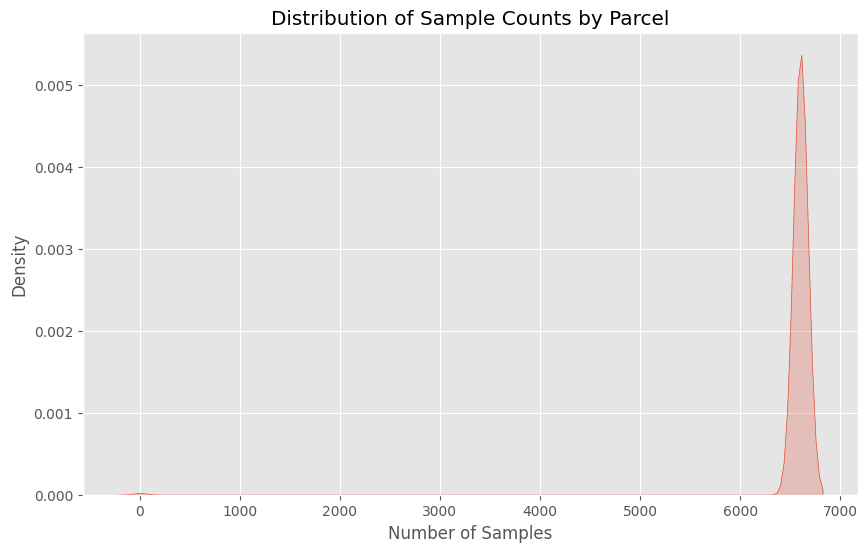

In [12]:
# Calculate the number of samples for each "codparcela"
sample_counts_by_parcel = meteo.groupby('codparcela').size().reset_index(name='sample_count')

# Plot the distribution of sample counts using a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(sample_counts_by_parcel['sample_count'], fill=True)
plt.title(f'Distribution of Sample Counts by Parcel')
plt.xlabel('Number of Samples')
plt.ylabel('Density')
plt.show()

In [45]:
meteo["codparcela"].nunique()

4848

<Axes: title={'center': "Distribution of indice's"}, xlabel='indice', ylabel='normalized freq'>

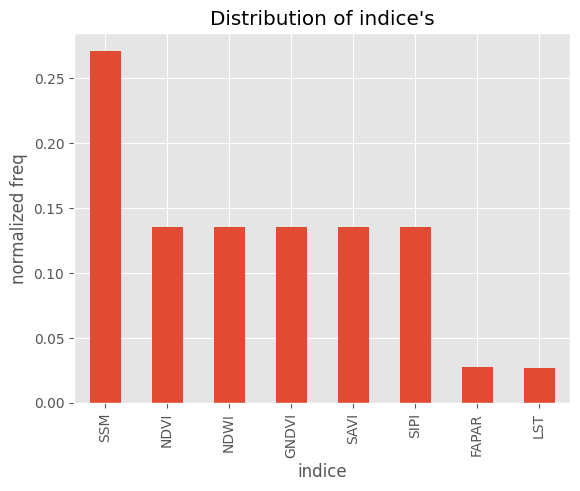

In [49]:
meteo["indice"].value_counts(normalize=True).sort_values(ascending=False).iloc[:30].plot(kind="bar", title="Distribution of indice's", xlabel="indice", ylabel="normalized freq")

In [73]:
print(meteo["indice"].value_counts(normalize=True).sort_values(ascending=False))

indice
SSM      0.271240
NDVI     0.134938
NDWI     0.134938
GNDVI    0.134938
SAVI     0.134938
SIPI     0.134938
FAPAR    0.027111
LST      0.026957
Name: proportion, dtype: float64


Different time resolutions for each weather indice. However, as we saw,\
those with small interval samples have lots of invalid rows because they\
in reality have bigger interval samples. We still have to drop them.

Insights:
- 8 weather indices: SSM, NDVI, NDWI, GNDVI, SAVI, SIPI, FAPAR, LST  
- Distribution of samples by indice:
    - SSM: 27,12%
    - NDVI: 13,49%
    - NDWI: 13,49%
    - GNDVI: 13,49%
    - SAVI: 13,49%
    - SIPI: 13,49%
    - FAPAR: 02,71%
    - LST: 02,69%

# Performing all the cleaning


1. Combine splitted indices
2. Drop all NaN’s for SSM.
3. NDVI, NDWI, SAVI, GNDVI and SIPI: drop rows with value exactly 0.0.
4. FAPAR: normalize values up until 2020 (dividing by 255) and drop rows with\
   value > 250, which are probably outliers.
5. Impute NaN’s for FAPAR and LST. (LOCF?)
6. Drop parcelas with latitude < 10 or latitude > 43. (NOT IMPLEMENTED)
7. Drop parcelas with not much data. (NOT IMPLEMENTED)

In [75]:
def combine_indices(df: pd.DataFrame) -> pd.DataFrame:
    df["indice"] = df["indice"].apply(lambda x: x.split("_")[-1].upper())
    return df


def drop_nans_for_indice(df: pd.DataFrame, indices: list[str]) -> pd.DataFrame:
    indice_filter = df["indice"].isin(indices)
    isnan_filter = df["valor"].isnull()
    return df.drop(df[indice_filter & isnan_filter].index)


def drop_zeros_for_indices(df: pd.DataFrame, indices: list[str]) -> pd.DataFrame:
    indice_filter = df["indice"].isin(indices)
    iszero_filter = df["valor"] == 0.0
    return df.drop(df[indice_filter & iszero_filter].index)


def normalize_fapar_values(df: pd.DataFrame) -> pd.DataFrame:
    indice_filter = df["indice"] == "FAPAR"
    not_normalized_filter = df["valor"] > 1.0
    MAX_VALUE = 255.0

    target_rows = df.loc[indice_filter & not_normalized_filter]
    target_rows["valor"] = target_rows["valor"].apply(lambda x: x / MAX_VALUE)
    df.update(target_rows)
    return df


def impute_nans_locf_for_indices(df: pd.DataFrame, indices: list[str]) -> pd.DataFrame:
    def impute_group(group):
        return group.fillna(method="ffill")

    df_imputed = df.groupby("indice").apply(
        lambda x: impute_group(x) if x.name in indices else x
    )

    return df_imputed.reset_index(drop=True)


def transform_raw_data(df: pd.DataFrame) -> pd.DataFrame:
    return (
        df.pipe(combine_indices)
        .pipe(drop_nans_for_indice, indices=["SSM"])
        .pipe(drop_zeros_for_indices, indices=["NDVI", "NDWI", "SAVI", "GNDVI", "SIPI"])
        .pipe(normalize_fapar_values)
        .pipe(impute_nans_locf_for_indices, ["FAPAR", "LST"])
    )

### Testing each transform step

In [28]:
# Test
print(meteo.shape)
meteo["indice"].value_counts()
combined_meteo = combine_indices(meteo)
print(combined_meteo.shape)
combined_meteo["indice"].value_counts()

(31892562, 6)
(31892562, 6)


indice
SSM      8650530
NDVI     4303530
NDWI     4303530
GNDVI    4303530
SAVI     4303530
SIPI     4303530
FAPAR     864642
LST       859740
Name: count, dtype: int64

In [31]:
clean_meteo = meteo.pipe(combine_indices).pipe(
    drop_nans_for_indice, indices=["SSM"]
)

In [20]:
# TEST: NO NULLS ON SSM
for indice, df in clean_meteo.groupby("indice"):
    print(indice, df["valor"].isnull().sum())
print(clean_meteo["indice"].value_counts())

FAPAR 71297
GNDVI 0
LST 276027
NDVI 0
NDWI 0
SAVI 0
SIPI 0
SSM 0
indice
NDVI     4303530
NDWI     4303530
GNDVI    4303530
SAVI     4303530
SIPI     4303530
SSM      2257397
FAPAR     864642
LST       859740
Name: count, dtype: int64


In [38]:
aux = clean_meteo.pipe(drop_zeros_for_indices, indices=["NDVI", "NDWI", "SAVI", "GNDVI", "SIPI"])

In [43]:
# TEST: NO ZEROS ON indices
print((clean_meteo["valor"] == 0.0).sum())
print(clean_meteo.shape)
for indice, df in clean_meteo.groupby("indice"):
    print(indice, (df["valor"] == 0.0).sum())

13152441
(25499429, 6)
FAPAR 9
GNDVI 2617862
LST 0
NDVI 2627520
NDWI 2627860
SAVI 2617860
SIPI 2627520
SSM 33810


In [41]:
print((aux["valor"] == 0.0).sum())
print(aux.shape)
for indice, df in aux.groupby("indice"):
    print(indice, (df["valor"] == 0.0).sum())

33819
(12380807, 6)
FAPAR 9
GNDVI 0
LST 0
NDVI 0
NDWI 0
SAVI 0
SIPI 0
SSM 33810


In [45]:
aux[aux["indice"] == "SSM"]["valor"].value_counts()

valor
0.0      33810
100.0    26724
121.0    18401
34.5     18167
36.0     18163
         ...  
93.5      4547
92.5      4531
90.5      4443
125.5     4293
126.0      811
Name: count, Length: 206, dtype: int64

In [49]:
print(aux[aux["indice"] == "FAPAR"]["valor"].value_counts())
print(aux[aux["indice"] == "FAPAR"]["valor"].value_counts().sort_index())

valor
0.228      7098
0.232      7059
0.236      7050
0.240      7029
0.220      6939
           ... 
218.000       1
0.936         1
0.928         1
0.892         1
230.000       1
Name: count, Length: 461, dtype: int64
valor
0.000         9
0.004         4
0.008         5
0.012         7
0.016        10
           ... 
231.000       3
232.000       4
233.000       6
235.000       5
255.000    1790
Name: count, Length: 461, dtype: int64


In [51]:
meteo_4 = aux.pipe(normalize_fapar_values)

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_66551/2035927839.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_rows['valor'] = target_rows['valor'].apply(lambda x: x/MAX_VALUE)


In [56]:
# TEST: SAME SHAPE, NO VALUES GREATER THAN 1.0 IN FAPAR INDICE
print(meteo_4[meteo_4["indice"] == "FAPAR"]["valor"].value_counts().sort_values())
print(meteo_4.shape)

valor
0.860000       1
0.908000       1
0.824000       1
0.900000       1
0.901961       1
            ... 
0.220000    6939
0.240000    7029
0.236000    7050
0.232000    7059
0.228000    7098
Name: count, Length: 460, dtype: int64
(12380807, 6)


In [67]:
meteo_5 = meteo_4.pipe(impute_nans_locf_for_indices, ["FAPAR", "LST"])

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_66551/863955300.py:44: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return group.fillna(method='ffill')
/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_66551/863955300.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imputed = df.groupby('indice').apply(lambda x: impute_group(x) if x.name in indices else x)


In [69]:
meteo_5.head()

fecha       codparcela        lat       lon indice     valor
0 2018-01-10  023-00109-00-00  37.146121 -2.769372  FAPAR  1.000000
1 2018-01-10  027-00047-00-00  37.140687 -2.772991  FAPAR  0.498039
2 2018-01-10  016-00014-00-00  37.157344 -2.816261  FAPAR  0.215686
3 2018-01-10  022-00237-00-00  37.146910 -2.795299  FAPAR  1.000000
4 2018-01-10  012-00154-00-00  37.205017 -1.919212  FAPAR  0.129412

In [70]:
# TEST: no nulls on FAPAR and LST
for indice, df in meteo_5.groupby("indice"):
    print(indice, df["valor"].isnull().sum())
print(clean_meteo["indice"].value_counts())

FAPAR 0
GNDVI 0
LST 2
NDVI 0
NDWI 0
SAVI 0
SIPI 0
SSM 0
indice
NDVI     4303530
NDWI     4303530
GNDVI    4303530
SAVI     4303530
SIPI     4303530
SSM      2257397
FAPAR     864642
LST       859740
Name: count, dtype: int64


In [71]:
meteo_5["codparcela"].value_counts()

codparcela
004-00277-00-00    2667
021-00089-00-00    2664
028-00004-02       2664
005-00008-03-00    2664
036-00067-00-00    2664
                   ... 
005-00079-05-00       4
002-00094-00-00       4
003-00054-00-00       4
042-00067-00-00       4
021-00003-07-00       4
Name: count, Length: 4848, dtype: int64

## Frequency of samples

In [74]:
df = meteo_5
codparcela = "021-00089-00-00"
codparcela_filter = df["codparcela"] == codparcela

df_parcela = df[codparcela_filter]
df_parcela['fecha'] = pd.to_datetime(df_parcela['fecha'])

for indice, group in df_parcela.groupby("indice"):
    sorted_group = group.sort_values("fecha")
    date_diff = sorted_group['fecha'].diff().dt.days
    frequency = date_diff.value_counts()
    print(indice, frequency)
    print("length:", len(group))

FAPAR fecha
10.0    138
11.0     34
8.0       4
21.0      1
9.0       1
Name: count, dtype: int64
length: 179
GNDVI fecha
5.0     189
10.0     35
2.0      32
3.0      30
15.0     14
8.0      14
7.0      13
20.0      5
0.0       4
12.0      3
13.0      3
23.0      2
30.0      1
25.0      1
27.0      1
18.0      1
Name: count, dtype: int64
length: 349
LST fecha
10.0    137
11.0     33
8.0       4
20.0      1
9.0       1
21.0      1
Name: count, dtype: int64
length: 178
NDVI fecha
5.0     190
10.0     34
2.0      31
3.0      29
15.0     14
8.0      14
7.0      12
20.0      5
0.0       4
12.0      3
13.0      3
23.0      2
25.0      1
30.0      1
27.0      1
18.0      1
17.0      1
Name: count, dtype: int64
length: 347
NDWI fecha
5.0     190
10.0     34
2.0      31
3.0      29
15.0     14
8.0      14
7.0      12
20.0      5
0.0       4
12.0      3
13.0      3
23.0      2
25.0      1
30.0      1
27.0      1
18.0      1
17.0      1
Name: count, dtype: int64
length: 347
SAVI fecha
5.0     189

/var/folders/fp/dm6c3_fn4p5fhx3hbqw7srvm0000gn/T/ipykernel_66551/3268909948.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcela['fecha'] = pd.to_datetime(df_parcela['fecha'])


Frequency of samples in days for each weather indice:
- FAPAR: 10
- GNDVI: 5
- LST: 10
- NDVI: 5
- NDWI: 5
- SAVI: 5
- SIPI: 5
- SSM: 5

# Feature engineering

For each weather indice create:
- Temporal differences: diff last 5, 10, 15 days.
- Moving Averages: average of 15 days, of 30 days
- Temporal statistics:
  - mean, median, std, min, max
  - of last 15 days, 30 days, et